# 🏢 Prédiction du Turnover - ESN TechNova

> **Objectif :** Construire un modèle de Machine Learning capable de prédire quels employés risquent de quitter l'entreprise, afin de permettre aux RH d'agir de manière préventive.

**Contexte métier :** TechNova est une ESN (Entreprise de Services Numériques) confrontée à un turnover important. Ce projet vise à identifier les facteurs de départ et à construire un outil prédictif actionnable.

---

## 📑 Table des Matières

0. **Configuration & Setup**
1. **Chargement & Exploration Initiale**
2. **Analyse Exploratoire (EDA)**
3. **Preprocessing & Feature Engineering**
4. **Modélisation - Baseline & Modèles Simples**
5. **Modélisation - Optimisation**
6. **Interprétabilité & Analyse des Erreurs**
7. **Améliorations Avancées**
8. **Conclusion & Recommandations**

---
# 0. Configuration & Setup

Cette section centralise tous les imports, constantes et fonctions utilitaires réutilisables dans le notebook. Cela garantit :
- 🔒 **Reproductibilité** : un seul endroit pour gérer les dépendances
- 🧹 **Lisibilité** : le code métier n'est pas pollué par les imports
- ♻️ **Réutilisabilité** : les fonctions helper sont définies une seule fois

## 0.1 Imports Centralisés

Tous les imports nécessaires au projet sont regroupés ici pour faciliter la maintenance et éviter les imports dispersés.

In [1]:
# ============================================================
# IMPORTS - Data Manipulation & Analysis
# ============================================================
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# IMPORTS - Visualization
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

# Configuration visuelle globale
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# ============================================================
# IMPORTS - Machine Learning (sklearn)
# ============================================================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    make_scorer
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFECV
from scipy.stats import randint, uniform

# ============================================================
# IMPORTS - Advanced ML
# ============================================================
import xgboost as xgb
import shap

# ============================================================
# IMPORTS - Imbalanced Learning
# ============================================================
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline

print("✅ Tous les imports chargés avec succès !")

✅ Tous les imports chargés avec succès !


## 0.2 Configuration Globale

Définition des constantes utilisées dans tout le notebook pour garantir la cohérence et la reproductibilité.

In [2]:
# ============================================================
# CONFIGURATION GLOBALE
# ============================================================

# Reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Chemins des données sources
DATA_PATH = 'source/'
SIRH_FILE = DATA_PATH + 'extrait_sirh.csv'
EVAL_FILE = DATA_PATH + 'extrait_eval.csv'
SONDAGE_FILE = DATA_PATH + 'extrait_sondage.csv'

# Variable cible
TARGET = 'a_quitte_l_entreprise'

# Ratio Train/Test
TEST_SIZE = 0.25

# Seuils d'analyse
CORRELATION_THRESHOLD = 0.90  # Pour suppression des colonnes fortement corrélées
CRAMER_V_THRESHOLD = 0.20     # Pour association catégorielle significative

print(f"🎯 Configuration chargée:")
print(f"   - Random State: {RANDOM_STATE}")
print(f"   - Target: '{TARGET}'")
print(f"   - Test Size: {TEST_SIZE*100:.0f}%")

🎯 Configuration chargée:
   - Random State: 42
   - Target: 'a_quitte_l_entreprise'
   - Test Size: 25%


## 0.3 Fonctions Utilitaires

Ces fonctions réutilisables sont définies une seule fois et appelées tout au long du notebook. Elles encapsulent la logique métier récurrente.

In [3]:
# ============================================================
# FONCTIONS UTILITAIRES - Data Loading & Cleaning
# ============================================================

def merge_and_report(sirh_df, eval_df, sondage_df, show=True):
    """
    Fusionne les 3 sources de données (SIRH, Évaluations, Sondage) et génère un rapport.

    Parameters:
    -----------
    sirh_df : DataFrame - Données SIRH
    eval_df : DataFrame - Données d'évaluation
    sondage_df : DataFrame - Données de sondage
    show : bool - Afficher le rapport de fusion

    Returns:
    --------
    tuple : (merged_df, report_dict)
    """
    eval_copy = eval_df.copy()

    # Parsing sécurisé de eval_number (format: "eval_XXX" -> XXX)
    if 'eval_number' in eval_copy.columns and eval_copy['eval_number'].dtype == object:
        eval_copy['eval_number'] = eval_copy['eval_number'].apply(
            lambda x: int(str(x).strip().split('_')[-1]) if pd.notna(x) else x
        )

    # Stockage des tailles avant fusion
    before = {'sirh': len(sirh_df), 'eval': len(eval_df), 'sondage': len(sondage_df)}

    # Double jointure interne
    merged = sirh_df.merge(eval_copy, left_on='id_employee', right_on='eval_number', how='inner')
    merged = merged.merge(sondage_df, left_on='id_employee', right_on='code_sondage', how='inner')

    # Rapport
    report = {
        'before': before,
        'after': len(merged),
        'lost_rows': before['sirh'] - len(merged),
        'retention_rate': len(merged) / before['sirh'] * 100
    }

    if show:
        print(f"📊 Rapport de fusion:")
        print(f"   - Lignes avant : SIRH={before['sirh']}, Eval={before['eval']}, Sondage={before['sondage']}")
        print(f"   - Lignes après fusion : {report['after']}")
        print(f"   - Lignes perdues : {report['lost_rows']} ({100 - report['retention_rate']:.1f}%)")

    return merged, report


def clean_basic(df, drop_cols=None):
    """
    Nettoyage de base du DataFrame : suppression de colonnes et parsing.

    Parameters:
    -----------
    df : DataFrame - Données à nettoyer
    drop_cols : list - Colonnes à supprimer

    Returns:
    --------
    DataFrame nettoyé
    """
    result = df.copy()

    if drop_cols is not None:
        result = result.drop(columns=drop_cols, errors='ignore')

    # Parsing de la colonne augmentation (format: "XX%" -> XX)
    col = 'augementation_salaire_precedente'
    if col in result.columns and result[col].dtype == object:
        result[col] = result[col].apply(
            lambda x: int(str(x).strip().split('%')[0]) if pd.notna(x) else x
        )

    return result.reset_index(drop=True)


def cramers_v(x, y):
    """
    Calcule le V de Cramér entre deux variables catégorielles.

    Le V de Cramér mesure l'association entre variables catégorielles.
    Valeurs : 0 (aucune association) à 1 (association parfaite)

    Parameters:
    -----------
    x, y : Series - Variables catégorielles à comparer

    Returns:
    --------
    float : V de Cramér
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # Correction pour les petits échantillons
    with np.errstate(divide='ignore', invalid='ignore'):
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


def classify_columns(df, continuous_threshold=20):
    """
    Classifie automatiquement les colonnes du DataFrame par type.

    Parameters:
    -----------
    df : DataFrame
    continuous_threshold : int - Seuil de valeurs uniques pour considérer une variable comme continue

    Returns:
    --------
    dict : {'continuous': [...], 'ordinal': [...], 'categorical': [...]}
    """
    data_types = {
        'continuous': [],      # Variables numériques continues
        'ordinal': [],         # Variables numériques ordinales (peu de valeurs)
        'categorical': []      # Variables textuelles
    }

    for col in df.columns:
        n_unique = df[col].nunique()
        dtype = df[col].dtype

        if dtype in ['int64', 'float64']:
            if n_unique > continuous_threshold:
                data_types['continuous'].append(col)
            elif n_unique > 1:
                data_types['ordinal'].append(col)
        elif dtype == 'object' and n_unique > 1:
            data_types['categorical'].append(col)

    return data_types


print("✅ Fonctions utilitaires chargées !")

✅ Fonctions utilitaires chargées !


---
# 1. Chargement & Exploration Initiale des Données

Cette section couvre le chargement des 3 sources de données RH, leur fusion et le nettoyage préliminaire nécessaire avant l'analyse exploratoire.

## 1.1 Chargement des Sources de Données

Nous disposons de **3 fichiers CSV** complémentaires :

| Fichier | Description | Clé de jointure |
|---------|-------------|-----------------|
| `extrait_sirh.csv` | Données RH (âge, salaire, ancienneté, département...) | `id_employee` |
| `extrait_eval.csv` | Évaluations de performance | `eval_number` |
| `extrait_sondage.csv` | Résultats du sondage de satisfaction | `code_sondage` |

In [4]:
# Chargement des 3 sources
sirh = pd.read_csv(SIRH_FILE)
eval_data = pd.read_csv(EVAL_FILE)
sondage = pd.read_csv(SONDAGE_FILE)

print(f"📂 Fichiers chargés avec succès !")
print(f"   - SIRH     : {sirh.shape[0]:,} lignes × {sirh.shape[1]} colonnes")
print(f"   - Eval     : {eval_data.shape[0]:,} lignes × {eval_data.shape[1]} colonnes")
print(f"   - Sondage  : {sondage.shape[0]:,} lignes × {sondage.shape[1]} colonnes")

📂 Fichiers chargés avec succès !
   - SIRH     : 1,470 lignes × 12 colonnes
   - Eval     : 1,470 lignes × 10 colonnes
   - Sondage  : 1,470 lignes × 12 colonnes


## 1.2 Aperçu Rapide des Données Sources

Avant toute fusion, examinons rapidement la structure et le contenu de chaque fichier.

In [5]:
# Fonction d'affichage condensé pour chaque source
def display_source_overview(df, name):
    """Affiche un résumé condensé d'un DataFrame source."""
    print(f"\n{'='*60}")
    print(f"📋 {name.upper()}")
    print(f"{'='*60}")

    # Types de données
    print(f"\n🔢 Types de données :")
    print(df.dtypes.value_counts().to_string())

    # Valeurs manquantes
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n⚠️ Valeurs manquantes :")
        print(missing[missing > 0].to_string())
    else:
        print(f"\n✅ Aucune valeur manquante")

    # Aperçu
    print(f"\n📊 Aperçu (3 premières lignes) :")
    display(df.head(3))

# Affichage pour chaque source
for df, name in [(sirh, "SIRH"), (eval_data, "Évaluations"), (sondage, "Sondage")]:
    display_source_overview(df, name)


📋 SIRH

🔢 Types de données :
int64     8
object    4

✅ Aucune valeur manquante

📊 Aperçu (3 premières lignes) :


,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0



📋 ÉVALUATIONS

🔢 Types de données :
int64     7
object    3

✅ Aucune valeur manquante

📊 Aperçu (3 premières lignes) :


,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %



📋 SONDAGE

🔢 Types de données :
int64     8
object    4

✅ Aucune valeur manquante

📊 Aperçu (3 premières lignes) :


,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0


## 1.3 Fusion des Datasets

Les 3 sources partagent un identifiant commun (l'employé). Nous allons les fusionner via des jointures internes pour obtenir un dataset unifié.

> ⚠️ **Point d'attention** : Une jointure interne peut exclure des lignes si les clés ne correspondent pas parfaitement. Nous surveillons le nombre de lignes perdues.

In [6]:
# Fusion des 3 sources avec rapport détaillé
merged_data, merge_report = merge_and_report(sirh, eval_data, sondage, show=True)

print(f"\n📐 Dimensions du dataset fusionné : {merged_data.shape}")
print(f"\n📋 Colonnes disponibles ({len(merged_data.columns)}) :")
print(merged_data.columns.tolist())

📊 Rapport de fusion:
   - Lignes avant : SIRH=1470, Eval=1470, Sondage=1470
   - Lignes après fusion : 1470
   - Lignes perdues : 0 (0.0%)

📐 Dimensions du dataset fusionné : (1470, 34)

📋 Colonnes disponibles (34) :
['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'eval_number', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'ayant_enfants', 'freque

## 1.4 Nettoyage Initial

Avant l'analyse exploratoire, nous effectuons un nettoyage préliminaire :
1. **Suppression des colonnes redondantes** (clés de jointure dupliquées)
2. **Suppression des colonnes à variance nulle** (une seule valeur)
3. **Parsing des données** (ex: "15%" → 15)

In [7]:
# Identification des colonnes à supprimer
cols_to_drop = merged_data.columns[
    (merged_data.nunique() == 1) |  # Variance nulle
    merged_data.columns.isin(['id_employee', 'code_sondage', 'eval_number'])  # Clés de jointure
].tolist()

print(f"🗑️ Colonnes à supprimer ({len(cols_to_drop)}) :")
for col in cols_to_drop:
    reason = "variance nulle" if merged_data[col].nunique() == 1 else "clé de jointure"
    print(f"   - {col} ({reason})")

# Application du nettoyage
merged_cleaned = clean_basic(merged_data, drop_cols=cols_to_drop)

print(f"\n✅ Nettoyage terminé !")
print(f"   - Dimensions finales : {merged_cleaned.shape[0]:,} lignes × {merged_cleaned.shape[1]} colonnes")

🗑️ Colonnes à supprimer (6) :
   - id_employee (clé de jointure)
   - nombre_heures_travailless (variance nulle)
   - eval_number (clé de jointure)
   - nombre_employee_sous_responsabilite (variance nulle)
   - code_sondage (clé de jointure)
   - ayant_enfants (variance nulle)

✅ Nettoyage terminé !
   - Dimensions finales : 1,470 lignes × 28 colonnes


In [8]:
# Classification automatique des colonnes par type
col_types = classify_columns(merged_cleaned)

print("📊 Classification des variables :")
print(f"\n🔵 Variables continues ({len(col_types['continuous'])}) :")
print(f"   {col_types['continuous']}")
print(f"\n🟡 Variables ordinales ({len(col_types['ordinal'])}) :")
print(f"   {col_types['ordinal']}")
print(f"\n🟢 Variables catégorielles ({len(col_types['categorical'])}) :")
print(f"   {col_types['categorical']}")

📊 Classification des variables :

🔵 Variables continues (5) :
   ['age', 'revenu_mensuel', 'annee_experience_totale', 'annees_dans_l_entreprise', 'distance_domicile_travail']

🟡 Variables ordinales (15) :
   ['nombre_experiences_precedentes', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'augementation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']

🟢 Variables catégorielles (8) :
   ['genre', 'statut_marital', 'departement', 'poste', 'heure_supplementaires', 'a_quitte_l_entreprise', 'domaine_etude', 'frequence_deplacement']


In [9]:
# Aperçu du dataset nettoyé
print("📋 Aperçu du dataset nettoyé (merged_cleaned) :")
merged_cleaned.info()
print("\n" + "="*60)
display(merged_cleaned.head())

📋 Aperçu du dataset nettoyé (merged_cleaned) :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   age                                        1470 non-null   int64 
 1   genre                                      1470 non-null   object
 2   revenu_mensuel                             1470 non-null   int64 
 3   statut_marital                             1470 non-null   object
 4   departement                                1470 non-null   object
 5   poste                                      1470 non-null   object
 6   nombre_experiences_precedentes             1470 non-null   int64 
 7   annee_experience_totale                    1470 non-null   int64 
 8   annees_dans_l_entreprise                   1470 non-null   int64 
 9   annees_dans_le_poste_actuel                1470 non-null   i

,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,...,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,8,6,4,...,11,Oui,0,0,1,2,Infra & Cloud,Occasionnel,0,5
1,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,10,10,7,...,23,Non,1,3,8,1,Infra & Cloud,Frequent,1,7
2,37,M,2090,Célibataire,Consulting,Consultant,6,7,0,0,...,15,Oui,0,3,2,2,Autre,Occasionnel,0,0
3,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,8,8,7,...,11,Non,0,3,3,4,Infra & Cloud,Frequent,3,0
4,27,M,3468,Marié(e),Consulting,Consultant,9,6,2,2,...,12,Non,1,3,2,1,Transformation Digitale,Occasionnel,2,2


### 💡 Bilan Section 1

| Étape | Résultat |
|-------|----------|
| **Sources chargées** | 3 fichiers CSV (SIRH, Eval, Sondage) |
| **Fusion** | Jointure interne sur l'ID employé |
| **Lignes conservées** | 100% (aucune perte) |
| **Colonnes après nettoyage** | ~25 variables exploitables |
| **Variable cible** | `a_quitte_l_entreprise` (Oui/Non) |

**Prochaine étape →** Analyse Exploratoire des Données (EDA)

# 2. Analyse Exploratoire des Données (EDA)

Cette section analyse en profondeur les données fusionnées pour :
- **Comprendre la distribution** de la variable cible (turnover)
- **Identifier les patterns** dans les variables explicatives
- **Détecter les corrélations** entre variables (numériques et catégorielles)
- **Formuler des hypothèses** métier pour guider la modélisation

> 📊 **Stratégie** : On travaille directement sur le dataset fusionné `merged_cleaned` pour une analyse cohérente et non-redondante.

## 2.1 Vue d'ensemble du Dataset

In [10]:
# Classification automatique des colonnes
col_types = classify_columns(merged_cleaned)

print("📊 Structure du Dataset fusionné :")
print(f"   • Observations : {merged_cleaned.shape[0]:,}")
print(f"   • Variables    : {merged_cleaned.shape[1]}")
print(f"\n📋 Classification des variables :")
print(f"   • Numériques continues : {len(col_types['continuous'])}")
print(f"   • Ordinales numériques : {len(col_types['ordinal'])}")
print(f"   • Catégorielles       : {len(col_types['categorical'])}")
print(f"\n🎯 Variable cible : '{TARGET}'")

# Aperçu de la classification
for cat, cols in col_types.items():
    if cols:
        print(f"\n{cat}: {cols[:5]}{'...' if len(cols) > 5 else ''}")

📊 Structure du Dataset fusionné :
   • Observations : 1,470
   • Variables    : 28

📋 Classification des variables :
   • Numériques continues : 5
   • Ordinales numériques : 15
   • Catégorielles       : 8

🎯 Variable cible : 'a_quitte_l_entreprise'

continuous: ['age', 'revenu_mensuel', 'annee_experience_totale', 'annees_dans_l_entreprise', 'distance_domicile_travail']

ordinal: ['nombre_experiences_precedentes', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste']...

categorical: ['genre', 'statut_marital', 'departement', 'poste', 'heure_supplementaires']...


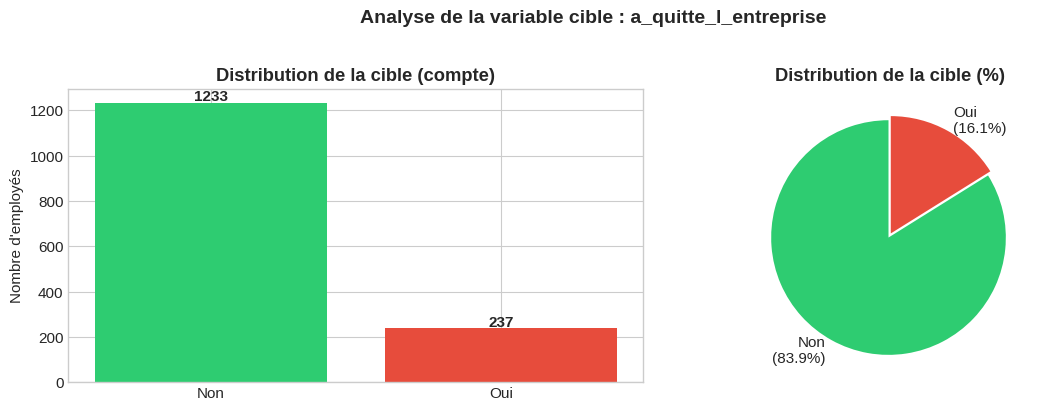


⚠️  Taux de départ global : 16.1%
   → Dataset déséquilibré - À considérer pour la stratégie de modélisation


In [11]:
# Distribution de la variable cible
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Compte absolu
target_counts = merged_cleaned[TARGET].value_counts()
colors = {'Oui': '#e74c3c', 'Non': '#2ecc71'}
axes[0].bar(target_counts.index, target_counts.values,
            color=[colors.get(x, '#3498db') for x in target_counts.index])
axes[0].set_title("Distribution de la cible (compte)", fontweight='bold')
axes[0].set_ylabel("Nombre d'employés")
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pourcentage
target_pct = target_counts / len(merged_cleaned) * 100
axes[1].pie(target_pct, labels=[f"{k}\n({v:.1f}%)" for k, v in target_pct.items()],
            colors=[colors.get(x, '#3498db') for x in target_pct.index],
            autopct='', startangle=90, explode=[0.02]*len(target_pct))
axes[1].set_title("Distribution de la cible (%)", fontweight='bold')

plt.suptitle(f"Analyse de la variable cible : {TARGET}", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Calcul du déséquilibre
taux_depart = (merged_cleaned[TARGET] == 'Oui').mean()
print(f"\n⚠️  Taux de départ global : {taux_depart:.1%}")
print(f"   → Dataset {'déséquilibré' if taux_depart < 0.3 or taux_depart > 0.7 else 'relativement équilibré'}"
      f" - À considérer pour la stratégie de modélisation")

In [12]:
# Statistiques descriptives des variables numériques
merged_cleaned.describe(include='number').T.style.format("{:.2f}").background_gradient(cmap='Blues', axis=1)

,count,mean,std,min,25%,50%,75%,max
age,1470.00,36.92,9.14,18.00,30.00,36.00,43.00,60.00
revenu_mensuel,1470.00,6502.93,4707.96,1009.00,2911.00,4919.00,8379.00,19999.00
nombre_experiences_precedentes,1470.00,2.69,2.50,0.00,1.00,2.00,4.00,9.00
annee_experience_totale,1470.00,11.28,7.78,0.00,6.00,10.00,15.00,40.00
annees_dans_l_entreprise,1470.00,7.01,6.13,0.00,3.00,5.00,9.00,40.00
annees_dans_le_poste_actuel,1470.00,4.23,3.62,0.00,2.00,3.00,7.00,18.00
satisfaction_employee_environnement,1470.00,2.72,1.09,1.00,2.00,3.00,4.00,4.00
note_evaluation_precedente,1470.00,2.73,0.71,1.00,2.00,3.00,3.00,4.00
niveau_hierarchique_poste,1470.00,2.06,1.11,1.00,1.00,2.00,3.00,5.00
satisfaction_employee_nature_travail,1470.00,2.73,1.10,1.00,2.00,3.00,4.00,4.00


## 2.2 Analyse Univariée

Visualisation de la distribution de chaque variable, segmentée par la variable cible pour identifier les différences entre les employés qui partent et ceux qui restent.

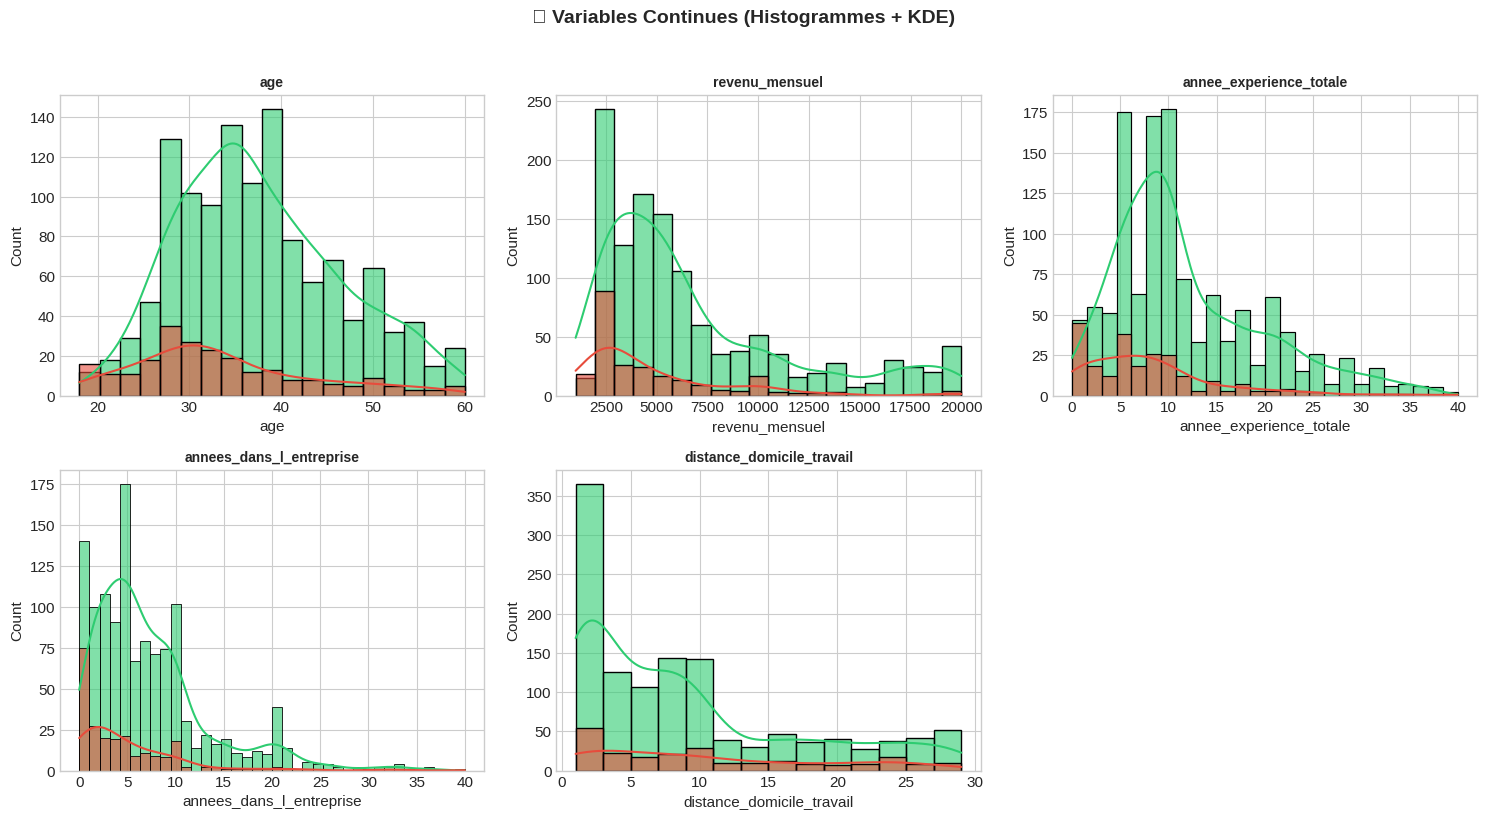

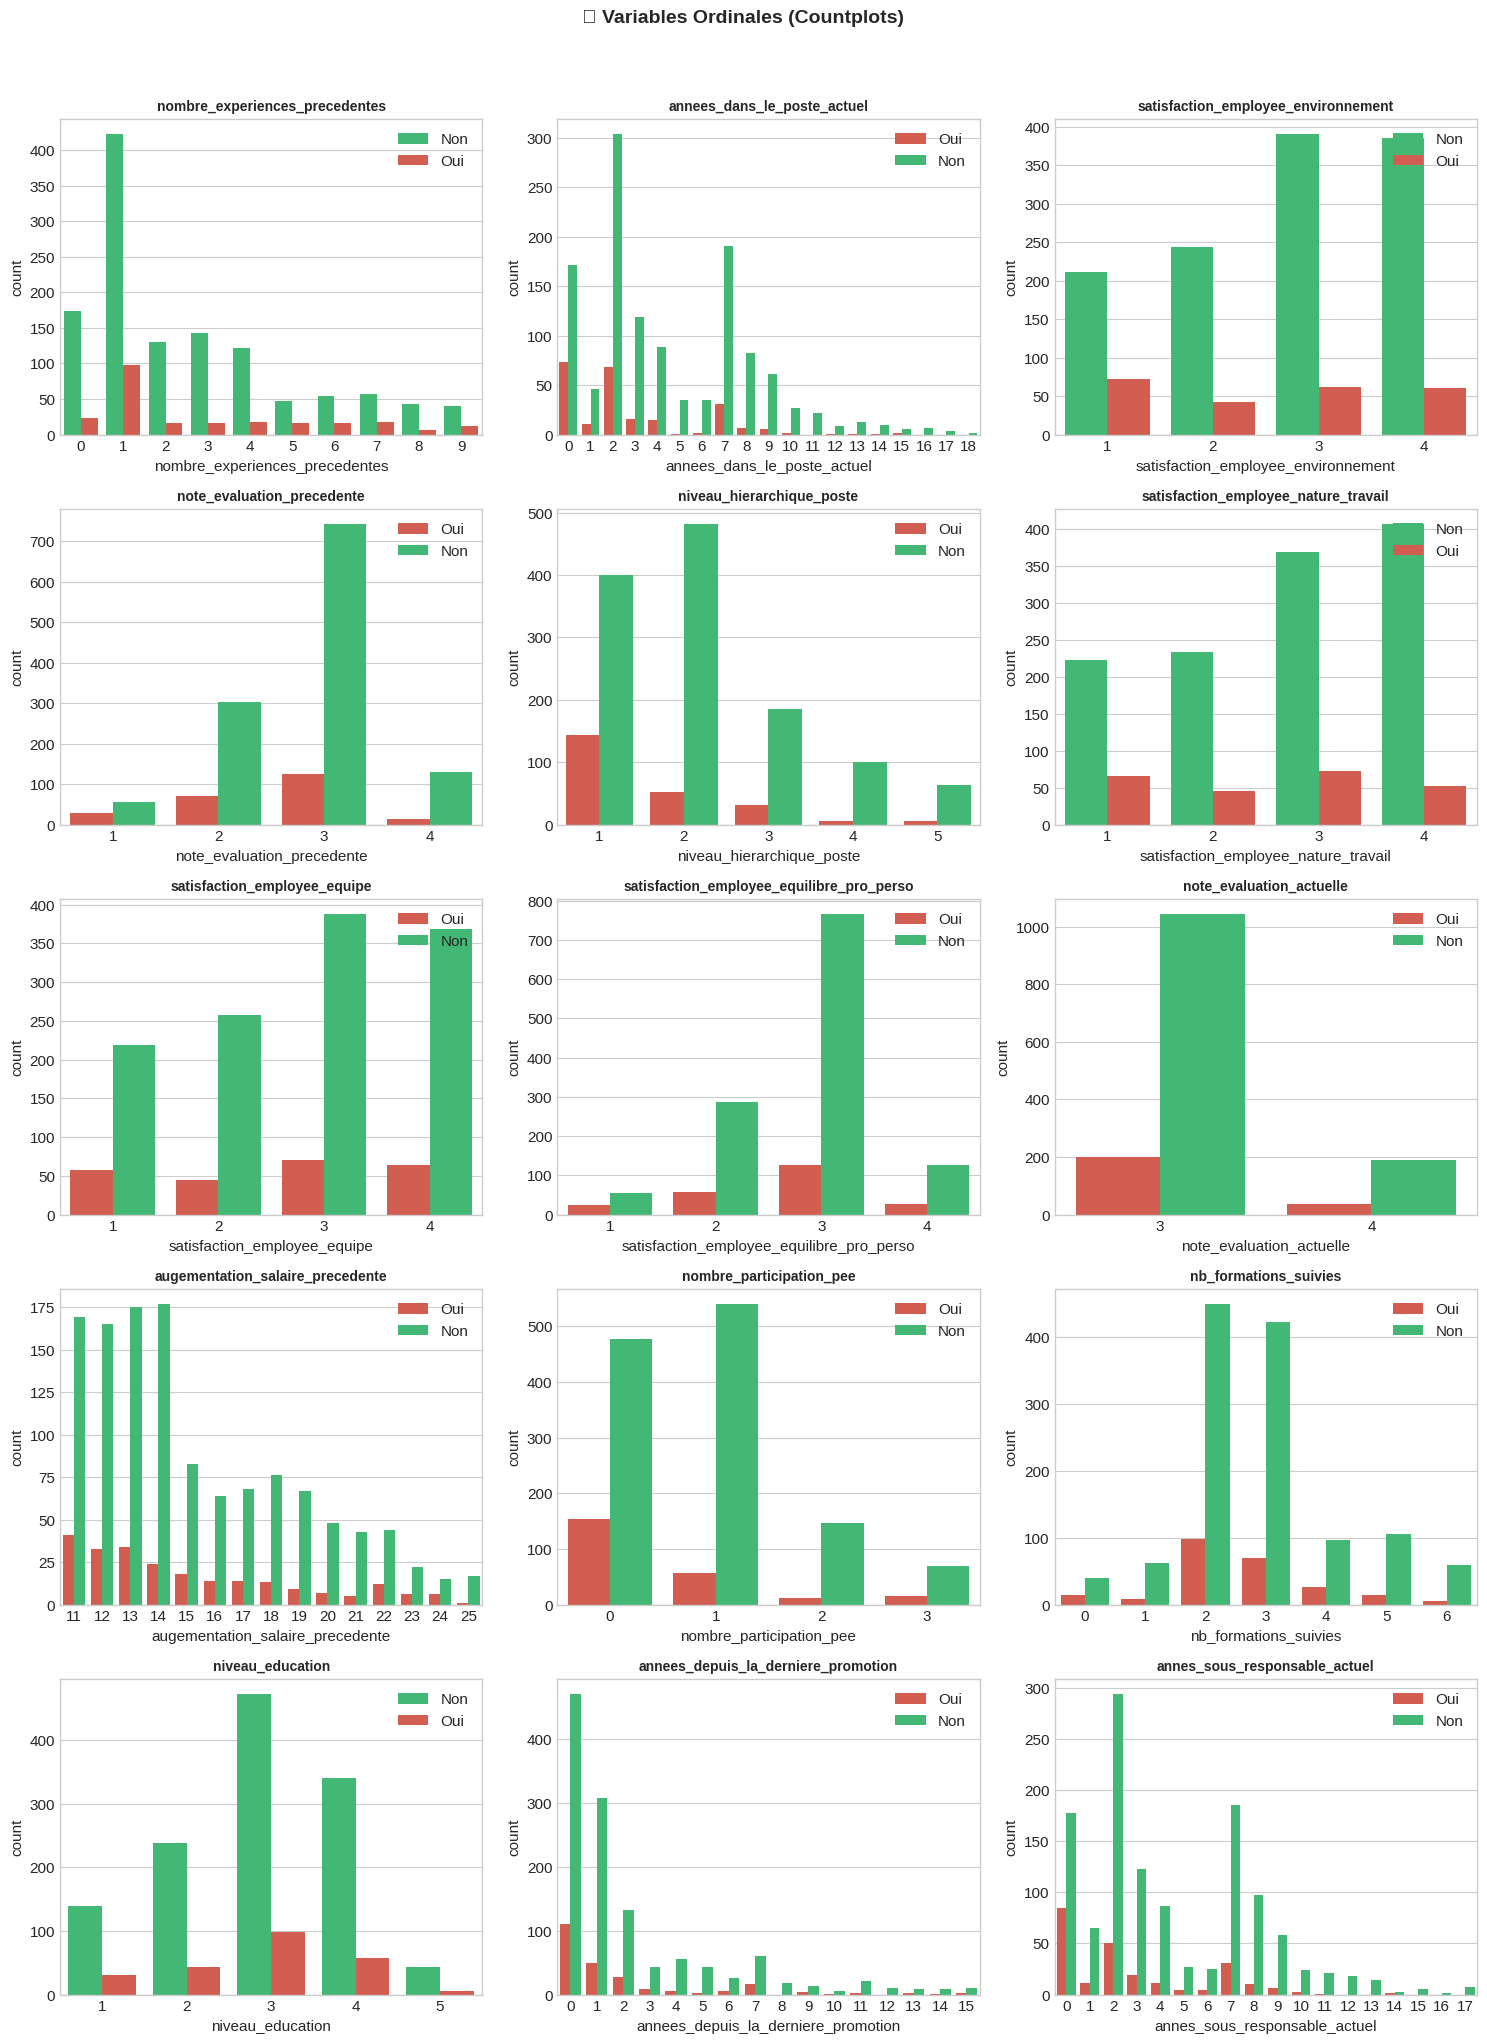

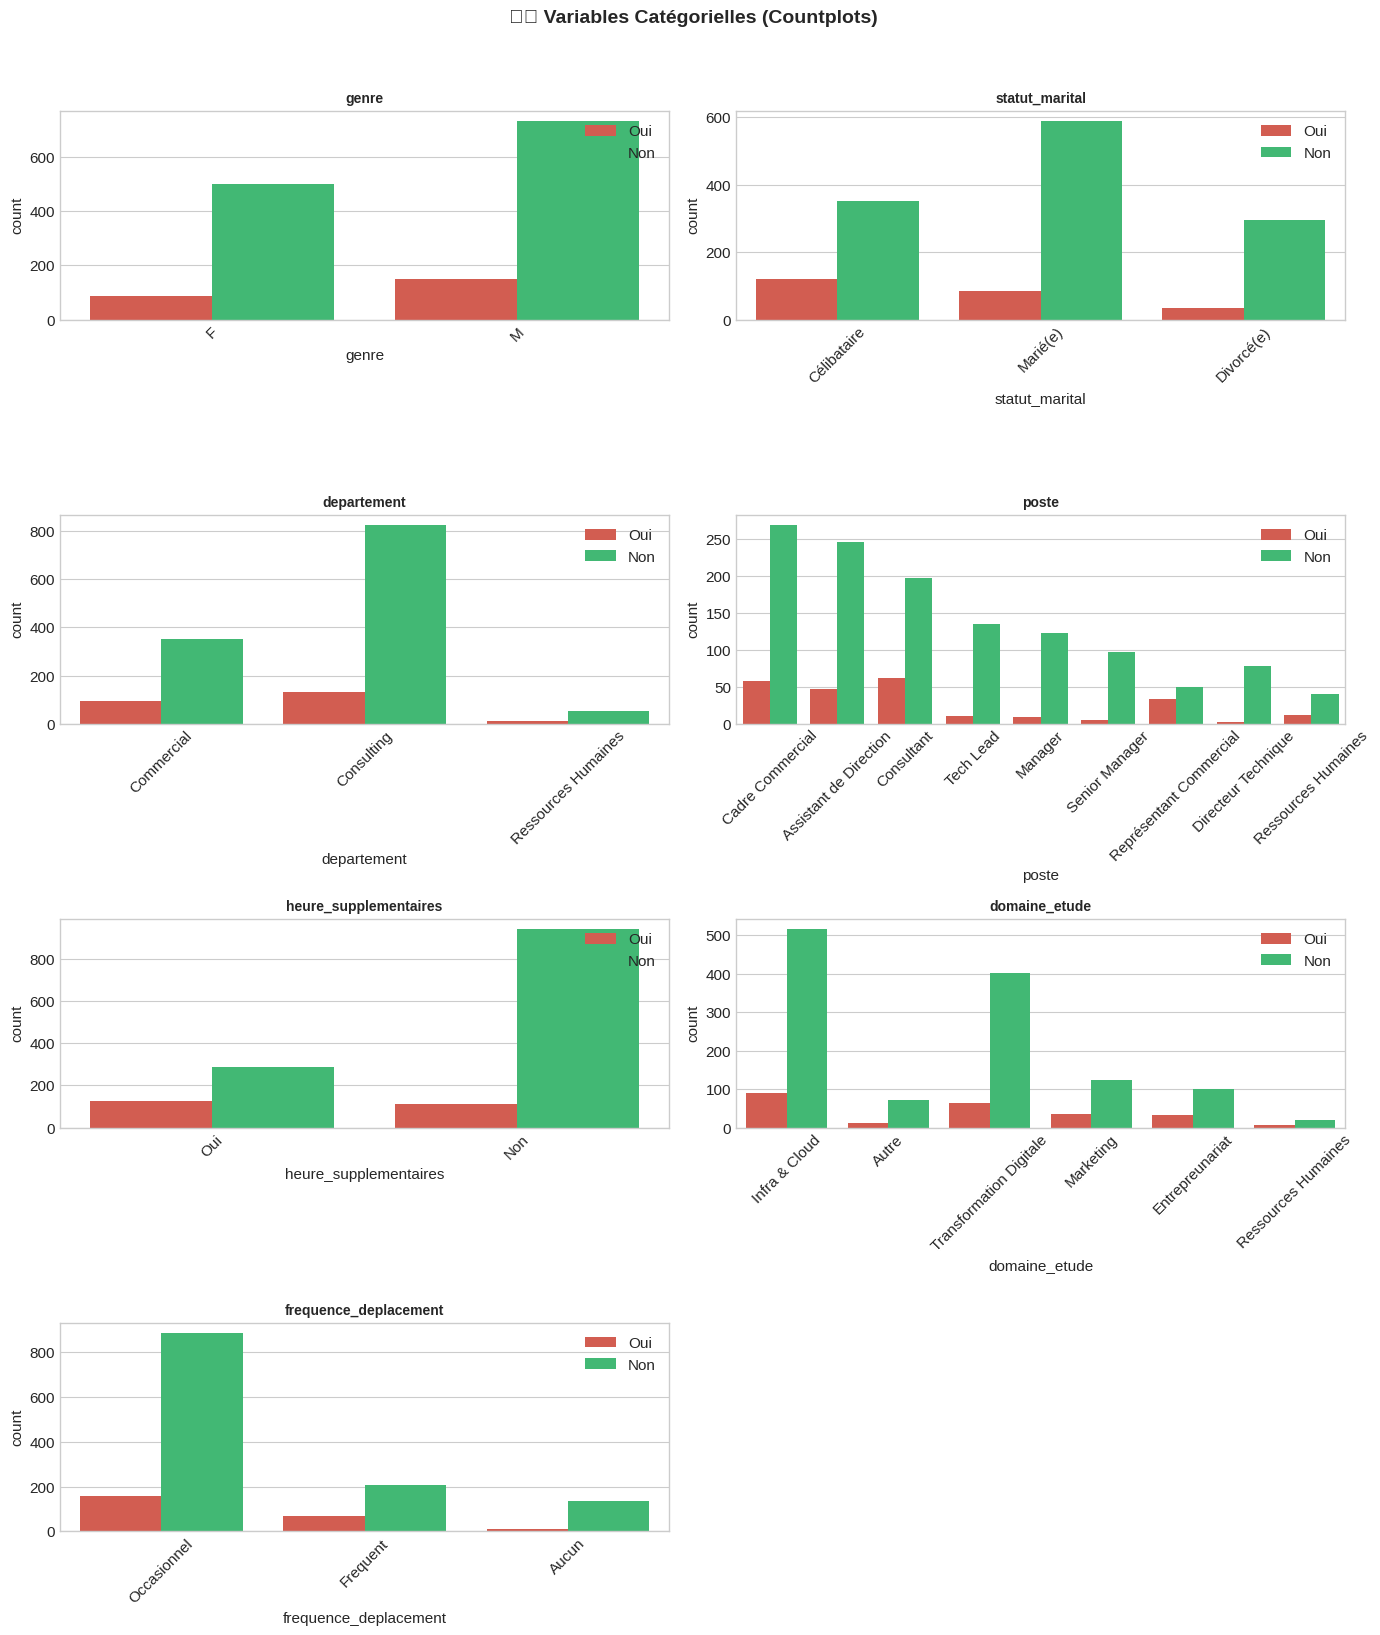

In [13]:
def plot_univariate_analysis(df, col_types, target, palette={'Oui': '#e74c3c', 'Non': '#2ecc71'}):
    """Génère les visualisations univariées pour toutes les variables."""

    # Variables continues - Histogrammes avec KDE
    continuous_cols = [c for c in col_types['continuous'] if c not in ['id_employee', 'eval_number', 'code_sondage']]
    if continuous_cols:
        n_cols = min(3, len(continuous_cols))
        n_rows = (len(continuous_cols) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        axes = np.array(axes).flatten() if n_rows * n_cols > 1 else [axes]

        for i, col in enumerate(continuous_cols):
            sns.histplot(data=df, x=col, hue=target, kde=True, ax=axes[i], palette=palette, alpha=0.6)
            axes[i].set_title(f'{col}', fontweight='bold', fontsize=10)
            axes[i].legend(title='', loc='upper right')

        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('📈 Variables Continues (Histogrammes + KDE)', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    # Variables ordinales - Countplots
    ordinal_cols = [c for c in col_types['ordinal'] if c != target]
    if ordinal_cols:
        n_cols = min(3, len(ordinal_cols))
        n_rows = (len(ordinal_cols) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        axes = np.array(axes).flatten() if n_rows * n_cols > 1 else [axes]

        for i, col in enumerate(ordinal_cols):
            sns.countplot(data=df, x=col, hue=target, ax=axes[i], palette=palette)
            axes[i].set_title(f'{col}', fontweight='bold', fontsize=10)
            axes[i].legend(title='', loc='upper right')

        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('📊 Variables Ordinales (Countplots)', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    # Variables catégorielles - Countplots
    cat_cols = [c for c in col_types['categorical'] if c != target]
    if cat_cols:
        n_cols = min(2, len(cat_cols))
        n_rows = (len(cat_cols) + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 4*n_rows))
        axes = np.array(axes).flatten() if n_rows * n_cols > 1 else [axes]

        for i, col in enumerate(cat_cols):
            sns.countplot(data=df, x=col, hue=target, ax=axes[i], palette=palette)
            axes[i].set_title(f'{col}', fontweight='bold', fontsize=10)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].legend(title='', loc='upper right')

        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('🏷️ Variables Catégorielles (Countplots)', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

# Exécution de l'analyse univariée
plot_univariate_analysis(merged_cleaned, col_types, TARGET)

## 2.3 Analyse Bivariée (vs Variable Cible)

Identification des variables les plus discriminantes pour prédire le départ. Nous analysons :
1. **Écart relatif des moyennes** entre les deux groupes (partants vs restants)
2. **Boxplots comparatifs** pour les variables à fort écart
3. **Taux de départ par segment** (profilage du risque)

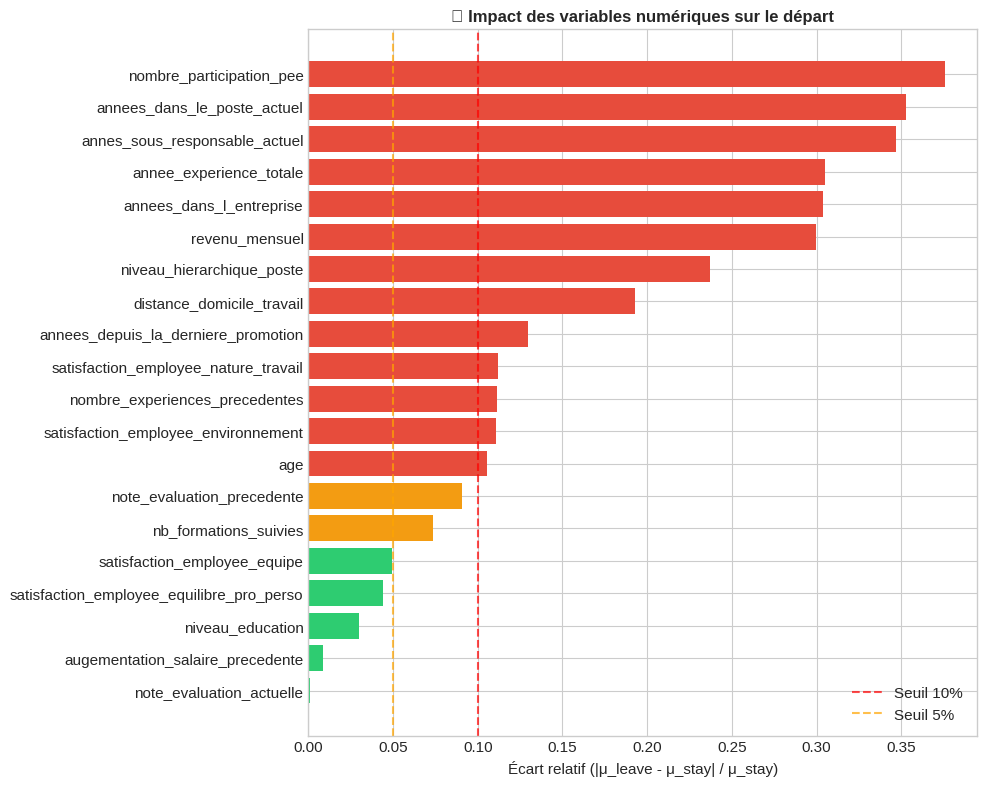


🔍 Top 5 variables avec le plus grand écart : ['nombre_participation_pee', 'annees_dans_le_poste_actuel', 'annes_sous_responsable_actuel', 'annee_experience_totale', 'annees_dans_l_entreprise']


In [14]:
# Séparation des groupes pour analyse comparative
df_leave = merged_cleaned[merged_cleaned[TARGET] == 'Oui']
df_stay = merged_cleaned[merged_cleaned[TARGET] == 'Non']

# Calcul de l'écart relatif des moyennes (uniquement sur les colonnes numériques)
numeric_cols = col_types['continuous'] + col_types['ordinal']
numeric_cols = [c for c in numeric_cols if c in merged_cleaned.select_dtypes(include=[np.number]).columns]

desc_leave = df_leave[numeric_cols].describe().loc['mean']
desc_stay = df_stay[numeric_cols].describe().loc['mean']

ecart_relatif = ((desc_leave - desc_stay).abs() / desc_stay.replace(0, np.nan)).dropna()
ecart_relatif_sorted = ecart_relatif.sort_values(ascending=True)

# Visualisation de l'écart relatif
fig, ax = plt.subplots(figsize=(10, max(6, len(ecart_relatif_sorted) * 0.4)))
colors = ['#e74c3c' if x > 0.1 else '#f39c12' if x > 0.05 else '#2ecc71' for x in ecart_relatif_sorted]
bars = ax.barh(ecart_relatif_sorted.index, ecart_relatif_sorted.values, color=colors)
ax.axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='Seuil 10%')
ax.axvline(x=0.05, color='orange', linestyle='--', alpha=0.7, label='Seuil 5%')
ax.set_xlabel("Écart relatif (|μ_leave - μ_stay| / μ_stay)")
ax.set_title("🎯 Impact des variables numériques sur le départ", fontweight='bold', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

# Top 5 variables à fort écart
top5 = ecart_relatif_sorted.tail(5).index.tolist()[::-1]
print(f"\n🔍 Top 5 variables avec le plus grand écart : {top5}")

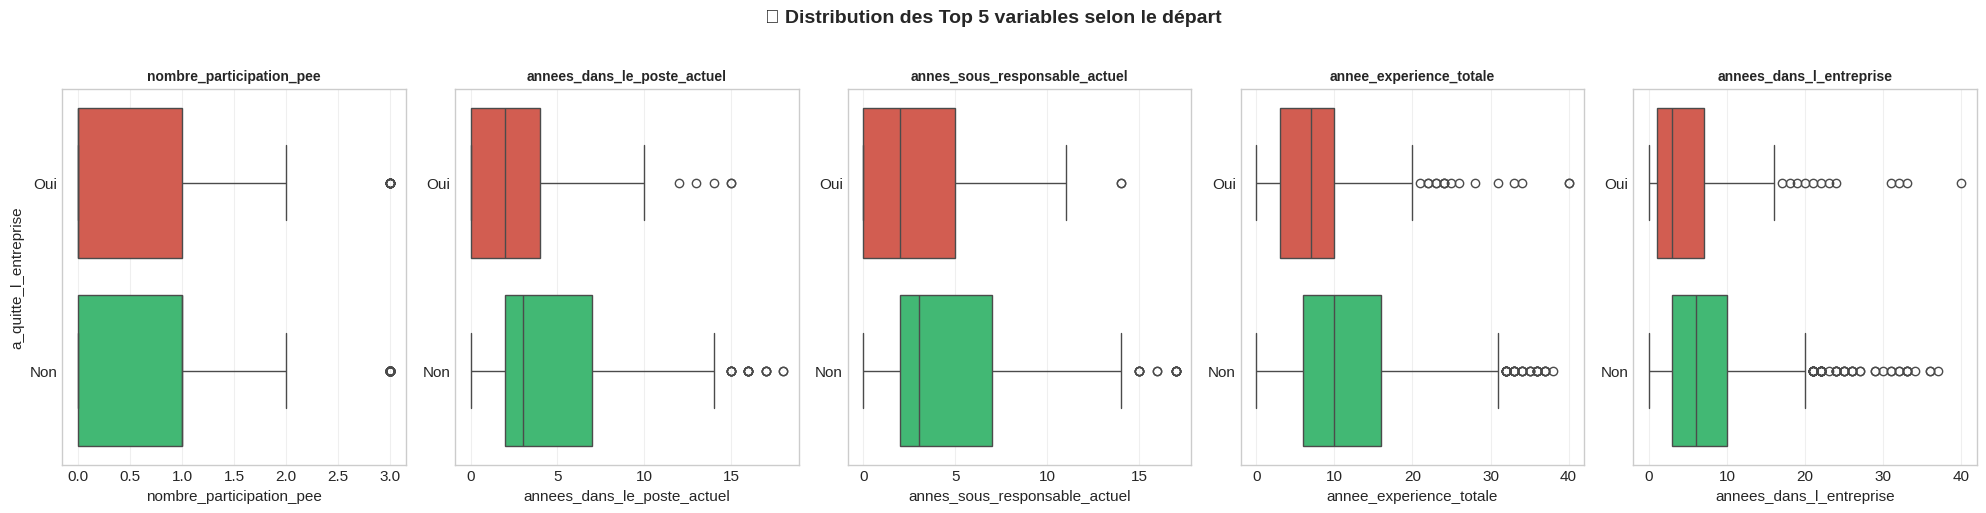

In [15]:
# Boxplots comparatifs pour les Top 5 variables
if len(top5) > 0:
    fig, axes = plt.subplots(1, min(5, len(top5)), figsize=(4*min(5, len(top5)), 5))
    axes = np.array([axes]).flatten() if len(top5) == 1 else axes

    for i, var in enumerate(top5[:5]):
        sns.boxplot(data=merged_cleaned, y=TARGET, x=var, ax=axes[i],
                    palette={'Oui': '#e74c3c', 'Non': '#2ecc71'}, orient='h')
        axes[i].set_title(f'{var}', fontweight='bold', fontsize=10)
        if i > 0:
            axes[i].set_ylabel('')
        axes[i].grid(axis='x', alpha=0.3)

    plt.suptitle("📦 Distribution des Top 5 variables selon le départ", fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

In [16]:
# Profilage du risque : taux de départ par segment pour les variables catégorielles
print(f"📊 Taux de départ global : {taux_depart:.1%}\n")
print("=" * 60)
print("🚨 SEGMENTS À RISQUE (taux de départ supérieur à la moyenne)")
print("=" * 60)

risk_data = []
cat_cols_analysis = col_types['categorical'] + [c for c in col_types['ordinal'] if merged_cleaned[c].nunique() <= 10]

for col in cat_cols_analysis:
    if col == TARGET:
        continue
    ct = pd.crosstab(merged_cleaned[col], merged_cleaned[TARGET], normalize='index')
    if 'Oui' in ct.columns:
        for segment in ct.index:
            rate = ct.loc[segment, 'Oui']
            if rate > taux_depart:
                risk_data.append({
                    'Variable': col,
                    'Segment': segment,
                    'Taux_Départ': rate,
                    'Écart_vs_Global': rate - taux_depart,
                    'Effectif': len(merged_cleaned[merged_cleaned[col] == segment])
                })

df_risk = pd.DataFrame(risk_data).sort_values('Taux_Départ', ascending=False)
display(df_risk.head(15).style.format({
    'Taux_Départ': '{:.1%}',
    'Écart_vs_Global': '{:+.1%}'
}).background_gradient(subset=['Taux_Départ'], cmap='Reds'))

📊 Taux de départ global : 16.1%

🚨 SEGMENTS À RISQUE (taux de départ supérieur à la moyenne)


,Variable,Segment,Taux_Départ,Écart_vs_Global,Effectif
6,poste,Représentant Commercial,39.8%,+23.6%,83
19,note_evaluation_precedente,1,33.7%,+17.6%,83
26,satisfaction_employee_equilibre_pro_perso,1,31.2%,+15.1%,80
8,heure_supplementaires,Oui,30.5%,+14.4%,416
32,nb_formations_suivies,0,27.8%,+11.7%,54
21,niveau_hierarchique_poste,1,26.3%,+10.2%,543
11,domaine_etude,Ressources Humaines,25.9%,+9.8%,27
1,statut_marital,Célibataire,25.5%,+9.4%,470
14,nombre_experiences_precedentes,5,25.4%,+9.3%,63
18,satisfaction_employee_environnement,1,25.4%,+9.2%,284


## 2.4 Analyse des Corrélations et Associations

Deux types d'analyses complémentaires :
- **Corrélation de Spearman** : pour les variables numériques (robuste aux outliers et relations non-linéaires)
- **V de Cramér** : pour mesurer l'association entre variables catégorielles

> 💡 **Interprétation** : Un coefficient > 0.3 indique une corrélation modérée, > 0.5 une corrélation forte.

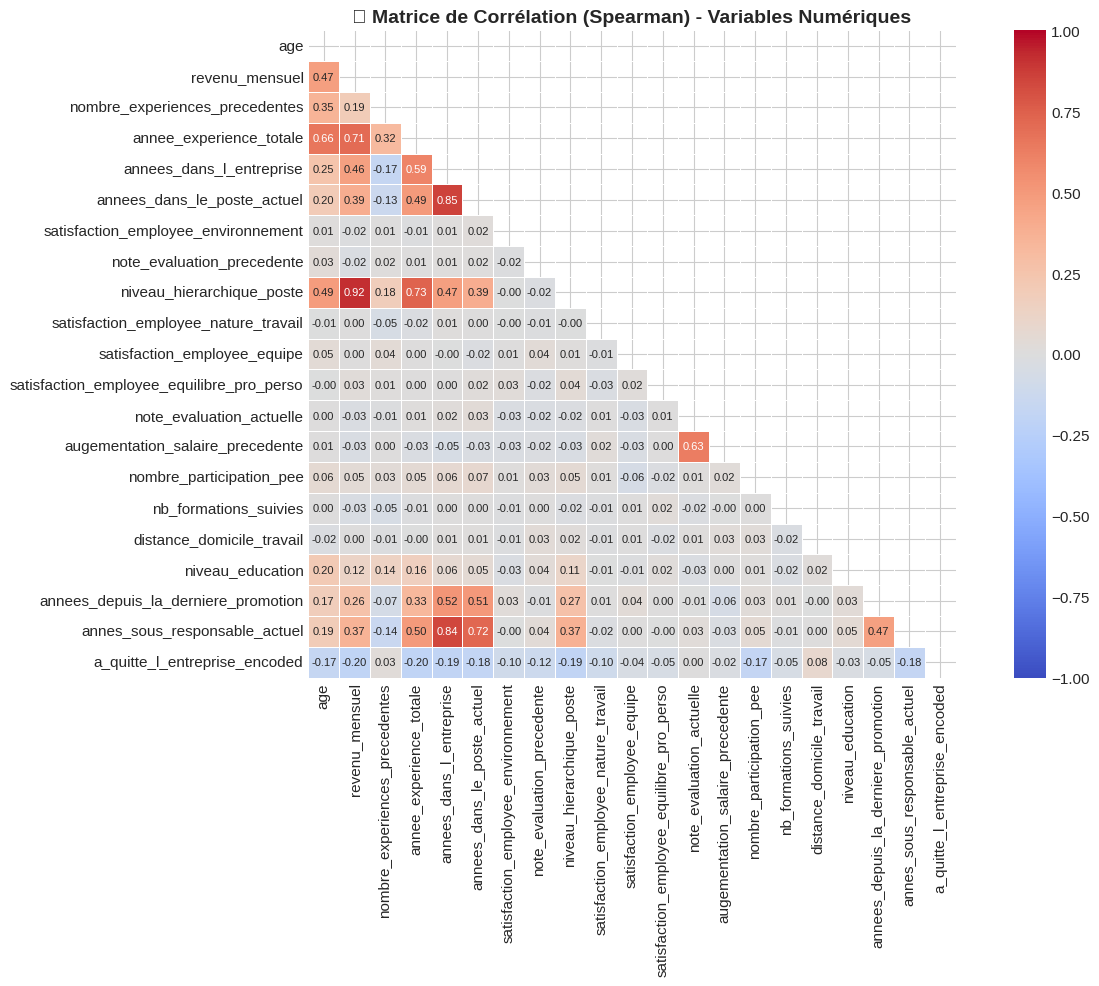


📌 Top corrélations avec 'a_quitte_l_entreprise':
   ↘️ annee_experience_totale: 0.199
   ↘️ revenu_mensuel: 0.198
   ↘️ annees_dans_l_entreprise: 0.190
   ↘️ niveau_hierarchique_poste: 0.190
   ↘️ annees_dans_le_poste_actuel: 0.181
   ↘️ annes_sous_responsable_actuel: 0.175
   ↘️ nombre_participation_pee: 0.172
   ↘️ age: 0.171
   ↘️ note_evaluation_precedente: 0.119
   ↘️ satisfaction_employee_nature_travail: 0.103


In [17]:
# Préparation : encodage de la cible pour les corrélations
df_corr = merged_cleaned.copy()
df_corr[TARGET + '_encoded'] = (df_corr[TARGET] == 'Oui').astype(int)

# Sélection des colonnes numériques pour Spearman
num_cols_corr = [c for c in merged_cleaned.select_dtypes(include=[np.number]).columns
                 if c not in ['id_employee', 'eval_number', 'code_sondage']]
num_cols_corr.append(TARGET + '_encoded')

# Matrice de corrélation Spearman
spearman_matrix = df_corr[num_cols_corr].corr(method='spearman')

# Visualisation
fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(spearman_matrix, dtype=bool))
sns.heatmap(spearman_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            vmin=-1, vmax=1, mask=mask, linewidths=0.5, square=True, ax=ax,
            annot_kws={'size': 8})
ax.set_title("🔗 Matrice de Corrélation (Spearman) - Variables Numériques", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Top corrélations avec la cible
target_corr = spearman_matrix[TARGET + '_encoded'].drop(TARGET + '_encoded').abs().sort_values(ascending=False)
print(f"\n📌 Top corrélations avec '{TARGET}':")
for var, corr in target_corr.head(10).items():
    direction = "↗️" if spearman_matrix.loc[var, TARGET + '_encoded'] > 0 else "↘️"
    print(f"   {direction} {var}: {corr:.3f}")

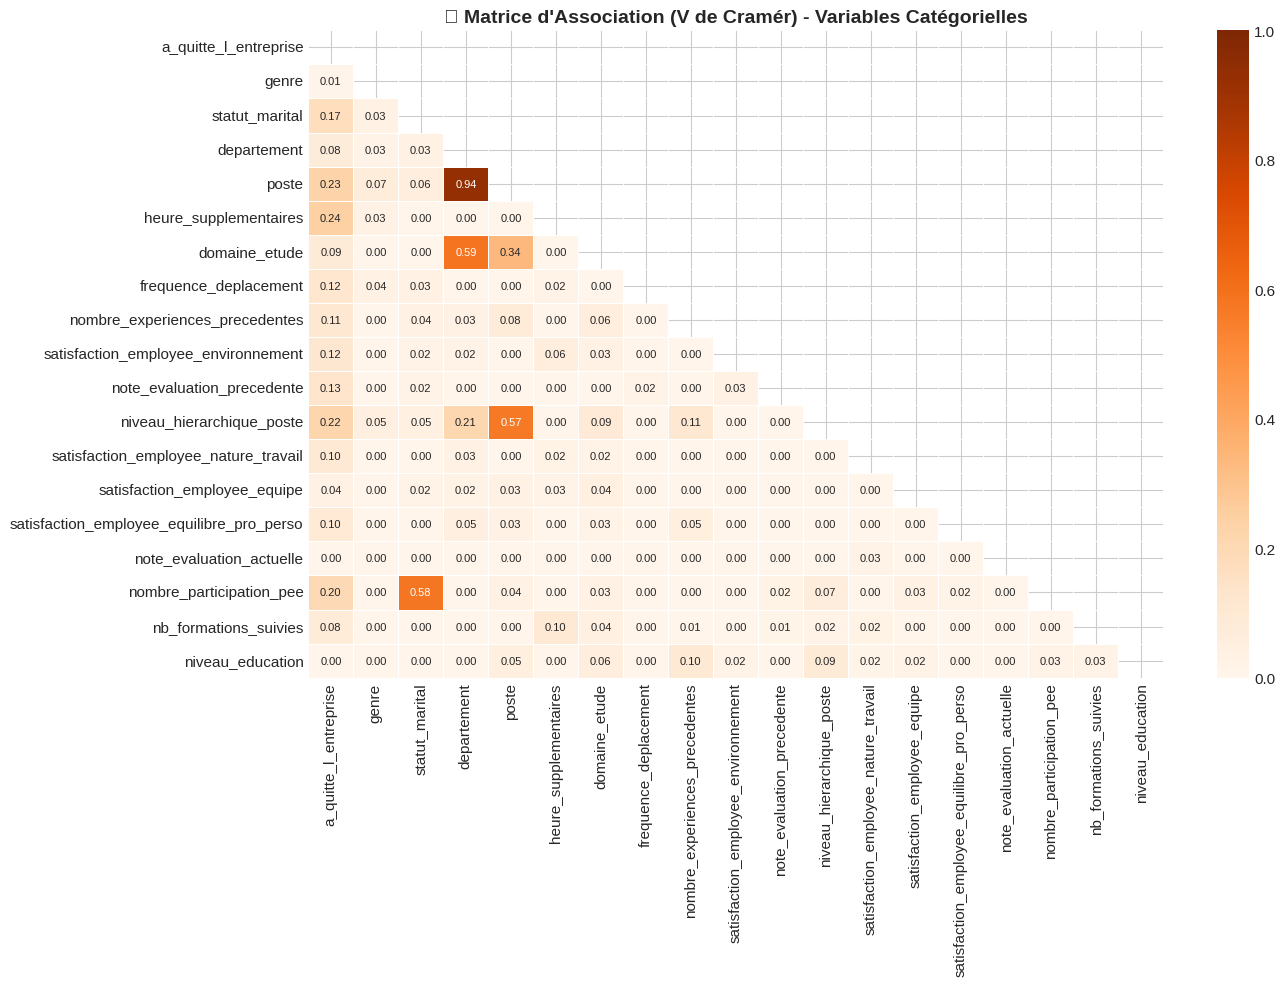


📌 Top associations avec 'a_quitte_l_entreprise' (V de Cramér):
   🟠 Modéré heure_supplementaires: 0.243
   🟠 Modéré poste: 0.231
   🟠 Modéré niveau_hierarchique_poste: 0.216
   🟠 Modéré nombre_participation_pee: 0.198
   🟠 Modéré statut_marital: 0.173
   🟢 Faible note_evaluation_precedente: 0.132
   🟢 Faible frequence_deplacement: 0.123
   🟢 Faible satisfaction_employee_environnement: 0.115
   🟢 Faible nombre_experiences_precedentes: 0.107
   🟢 Faible satisfaction_employee_nature_travail: 0.099


In [18]:
# V de Cramér pour les variables catégorielles
cat_cols_cramer = [TARGET] + [c for c in col_types['categorical'] if c != TARGET]
# Ajouter les variables ordinales avec peu de modalités
cat_cols_cramer += [c for c in col_types['ordinal'] if merged_cleaned[c].nunique() <= 10]
cat_cols_cramer = list(dict.fromkeys(cat_cols_cramer))  # Supprimer doublons en préservant l'ordre

# Calcul de la matrice de Cramér
cramers_matrix = pd.DataFrame(index=cat_cols_cramer, columns=cat_cols_cramer, dtype=float)
for col1 in cat_cols_cramer:
    for col2 in cat_cols_cramer:
        cramers_matrix.loc[col1, col2] = cramers_v(merged_cleaned[col1], merged_cleaned[col2])

# Visualisation
fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(cramers_matrix, dtype=bool))
sns.heatmap(cramers_matrix.astype(float), annot=True, fmt=".2f", cmap='Oranges',
            vmin=0, vmax=1, mask=mask, linewidths=0.5, ax=ax, annot_kws={'size': 8})
ax.set_title("🔗 Matrice d'Association (V de Cramér) - Variables Catégorielles", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Top associations avec la cible
target_cramer = cramers_matrix[TARGET].drop(TARGET).astype(float).sort_values(ascending=False)
print(f"\n📌 Top associations avec '{TARGET}' (V de Cramér):")
for var, v in target_cramer.head(10).items():
    strength = "🔴 Fort" if v > 0.3 else "🟠 Modéré" if v > 0.15 else "🟢 Faible"
    print(f"   {strength} {var}: {v:.3f}")

## 2.5 Conclusions de l'EDA

### 📊 Synthèse des insights clés

In [19]:
# Résumé automatique des findings
print("=" * 70)
print("📋 BILAN DE L'ANALYSE EXPLORATOIRE")
print("=" * 70)

print(f"\n1️⃣  DÉSÉQUILIBRE DE LA CIBLE")
print(f"    • Taux de départ : {taux_depart:.1%}")
print(f"    • Implication : {'Utiliser SMOTE ou class_weight pour rééquilibrer' if taux_depart < 0.3 else 'Dataset relativement équilibré'}")

print(f"\n2️⃣  VARIABLES NUMÉRIQUES LES PLUS DISCRIMINANTES")
for i, (var, ecart) in enumerate(ecart_relatif_sorted.tail(5)[::-1].items(), 1):
    print(f"    {i}. {var} (écart relatif: {ecart:.1%})")

print(f"\n3️⃣  SEGMENTS À PLUS HAUT RISQUE")
if len(df_risk) > 0:
    for _, row in df_risk.head(5).iterrows():
        print(f"    • {row['Variable']}='{row['Segment']}' → {row['Taux_Départ']:.1%} de départ (+{row['Écart_vs_Global']:.1%} vs global)")

print(f"\n4️⃣  CORRÉLATIONS NOTABLES AVEC LA CIBLE")
print("    Spearman (numériques):")
for var, corr in target_corr.head(3).items():
    print(f"      • {var}: {corr:.3f}")
print("    Cramér V (catégorielles):")
for var, v in target_cramer.head(3).items():
    print(f"      • {var}: {v:.3f}")

print(f"\n5️⃣  RECOMMANDATIONS POUR LA MODÉLISATION")
print("    • Feature Engineering : créer des ratios (ancienneté/âge, salaire/expérience)")
print("    • Encodage : One-Hot pour catégorielles à faible cardinalité, Target pour haute cardinalité")
print("    • Gestion du déséquilibre : SMOTE, class_weight='balanced', ou sous-échantillonnage")
print("    • Variables à surveiller : celles identifiées avec fort écart relatif et V de Cramér élevé")
print("=" * 70)

📋 BILAN DE L'ANALYSE EXPLORATOIRE

1️⃣  DÉSÉQUILIBRE DE LA CIBLE
    • Taux de départ : 16.1%
    • Implication : Utiliser SMOTE ou class_weight pour rééquilibrer

2️⃣  VARIABLES NUMÉRIQUES LES PLUS DISCRIMINANTES
    1. nombre_participation_pee (écart relatif: 37.6%)
    2. annees_dans_le_poste_actuel (écart relatif: 35.3%)
    3. annes_sous_responsable_actuel (écart relatif: 34.7%)
    4. annee_experience_totale (écart relatif: 30.5%)
    5. annees_dans_l_entreprise (écart relatif: 30.4%)

3️⃣  SEGMENTS À PLUS HAUT RISQUE
    • poste='Représentant Commercial' → 39.8% de départ (+23.6% vs global)
    • note_evaluation_precedente='1' → 33.7% de départ (+17.6% vs global)
    • satisfaction_employee_equilibre_pro_perso='1' → 31.2% de départ (+15.1% vs global)
    • heure_supplementaires='Oui' → 30.5% de départ (+14.4% vs global)
    • nb_formations_suivies='0' → 27.8% de départ (+11.7% vs global)

4️⃣  CORRÉLATIONS NOTABLES AVEC LA CIBLE
    Spearman (numériques):
      • annee_experienc

# 3. Préparation des Données & Feature Engineering

Cette section prépare les données pour la modélisation en suivant les bonnes pratiques ML :
1. **Séparation X/y** avant tout preprocessing (éviter les fuites de données)
2. **Feature Engineering** : création de variables métier pertinentes
3. **Pipeline sklearn** : encapsulation du preprocessing pour reproductibilité
4. **Gestion du déséquilibre** : stratégies pour la classe minoritaire

> ⚠️ **Principe clé** : Le preprocessing (scaling, encoding) doit être *fit* uniquement sur le train et *transform* sur le test.

## 3.1 Séparation Features / Target & Train-Test Split

La séparation train/test doit être faite **avant** le feature engineering et le preprocessing pour éviter toute fuite de données.

In [20]:
# Colonnes à exclure (identifiants, constantes)
COLS_TO_DROP = ['id_employee', 'code_sondage', 'eval_number']

# Préparation du dataset
df_model = merged_cleaned.copy()

# Suppression des colonnes inutiles
cols_to_drop_existing = [c for c in COLS_TO_DROP if c in df_model.columns]
df_model = df_model.drop(columns=cols_to_drop_existing)

# Séparation X / y
X = df_model.drop(columns=[TARGET])
y = df_model[TARGET].map({'Oui': 1, 'Non': 0})  # Encodage binaire de la cible

print(f"📊 Dimensions du dataset :")
print(f"   • X : {X.shape[0]} observations × {X.shape[1]} features")
print(f"   • y : {y.shape[0]} observations")
print(f"\n🎯 Distribution de la cible :")
print(f"   • Classe 0 (Non) : {(y == 0).sum()} ({(y == 0).mean():.1%})")
print(f"   • Classe 1 (Oui) : {(y == 1).sum()} ({(y == 1).mean():.1%})")

📊 Dimensions du dataset :
   • X : 1470 observations × 27 features
   • y : 1470 observations

🎯 Distribution de la cible :
   • Classe 0 (Non) : 1233 (83.9%)
   • Classe 1 (Oui) : 237 (16.1%)


In [21]:
# Train-Test Split STRATIFIÉ (conserve les proportions de la cible)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y  # Important pour dataset déséquilibré
)

print(f"✅ Split réalisé (75% train / 25% test)")
print(f"\n📊 Dimensions :")
print(f"   • Train : {X_train.shape[0]} observations")
print(f"   • Test  : {X_test.shape[0]} observations")
print(f"\n🎯 Vérification stratification :")
print(f"   • Train - Classe 1 : {y_train.mean():.1%}")
print(f"   • Test  - Classe 1 : {y_test.mean():.1%}")

✅ Split réalisé (75% train / 25% test)

📊 Dimensions :
   • Train : 1102 observations
   • Test  : 368 observations

🎯 Vérification stratification :
   • Train - Classe 1 : 16.2%
   • Test  - Classe 1 : 16.0%


## 3.2 Feature Engineering

Création de nouvelles variables métier basées sur l'analyse exploratoire :
- **Ratios de frustration** : salaire vs expérience/âge
- **Indicateurs de stagnation** : évolution de carrière, fidélité au manager
- **Job hopping** : durée moyenne par emploi
- **Discrétisation** : transformation de variables continues en catégories

In [22]:
def create_features(df):
    """
    Crée des features métier pertinentes pour la prédiction du turnover.
    Applique les mêmes transformations sur train et test.
    """
    df = df.copy()

    # 1. Ratios de Frustration (salaire vs expérience/âge)
    if 'revenu_mensuel' in df.columns:
        if 'annee_experience_totale' in df.columns:
            df['ratio_revenu_experience'] = df['revenu_mensuel'] / (df['annee_experience_totale'] + 1)
        if 'age' in df.columns:
            df['ratio_revenu_age'] = df['revenu_mensuel'] / df['age']

    # 2. Indicateurs de Stagnation
    if 'annees_dans_le_poste_actuel' in df.columns and 'annees_dans_l_entreprise' in df.columns:
        df['taux_stagnation'] = df['annees_dans_le_poste_actuel'] / (df['annees_dans_l_entreprise'] + 1)

    if 'annes_sous_responsable_actuel' in df.columns and 'annees_dans_le_poste_actuel' in df.columns:
        df['fidelite_manager'] = df['annes_sous_responsable_actuel'] / (df['annees_dans_le_poste_actuel'] + 1)

    # 3. Job Hopping (faible = turnover fréquent)
    if 'annee_experience_totale' in df.columns and 'nombre_experiences_precedentes' in df.columns:
        df['duree_moyenne_par_job'] = df['annee_experience_totale'] / (df['nombre_experiences_precedentes'] + 1)

    # 4. Discrétisation de la distance domicile-travail
    if 'distance_domicile_travail' in df.columns:
        df['distance_cat'] = pd.cut(
            df['distance_domicile_travail'],
            bins=[-1, 2, 7, 14, np.inf],
            labels=[0, 1, 2, 3]  # proche, moyen, loin, très loin
        ).astype(int)

    return df

# Liste des nouvelles features créées
NEW_FEATURES = ['ratio_revenu_experience', 'ratio_revenu_age', 'taux_stagnation',
                'fidelite_manager', 'duree_moyenne_par_job', 'distance_cat']

# Application sur train et test
X_train_fe = create_features(X_train)
X_test_fe = create_features(X_test)

# Affichage des nouvelles features
created = [f for f in NEW_FEATURES if f in X_train_fe.columns]
print(f"✅ {len(created)} nouvelles features créées : {created}")
print(f"\n📊 Aperçu des nouvelles features (train) :")
display(X_train_fe[created].describe().T.style.format("{:.2f}").background_gradient(cmap='Blues', axis=1))

✅ 6 nouvelles features créées : ['ratio_revenu_experience', 'ratio_revenu_age', 'taux_stagnation', 'fidelite_manager', 'duree_moyenne_par_job', 'distance_cat']

📊 Aperçu des nouvelles features (train) :


,count,mean,std,min,25%,50%,75%,max
ratio_revenu_experience,1102.00,589.36,283.14,95.29,386.70,552.06,733.79,1904.00
ratio_revenu_age,1102.00,170.82,99.81,36.03,94.92,141.84,223.01,556.00
taux_stagnation,1102.00,0.48,0.27,0.00,0.33,0.50,0.67,0.88
fidelite_manager,1102.00,0.83,0.99,0.00,0.40,0.67,1.00,9.00
duree_moyenne_par_job,1102.00,4.18,3.95,0.00,1.67,3.00,5.00,38.00
distance_cat,1102.00,1.44,1.15,0.00,0.00,1.00,2.75,3.00


## 3.3 Pipeline de Preprocessing (sklearn)

Construction d'un `ColumnTransformer` pour appliquer les transformations appropriées :
- **Variables numériques** : `StandardScaler` (normalisation)
- **Variables catégorielles** : `OneHotEncoder` (encodage one-hot)
- **Variables binaires** : `OrdinalEncoder` (0/1)

> 💡 Le pipeline garantit que le même preprocessing est appliqué de manière cohérente sur train et test.

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

# Classification automatique des colonnes après feature engineering
def get_column_types(df):
    """Identifie les types de colonnes pour le preprocessing."""
    numeric_cols = []
    binary_cols = []
    categorical_cols = []

    for col in df.columns:
        n_unique = df[col].nunique()
        dtype = df[col].dtype

        if dtype == 'object':
            if n_unique == 2:
                binary_cols.append(col)
            else:
                categorical_cols.append(col)
        elif dtype in ['int64', 'float64']:
            if n_unique == 2:
                binary_cols.append(col)
            elif n_unique > 10:  # Continue
                numeric_cols.append(col)
            else:  # Ordinal traité comme numérique
                numeric_cols.append(col)

    return numeric_cols, binary_cols, categorical_cols

# Identification des types de colonnes
numeric_cols, binary_cols, categorical_cols = get_column_types(X_train_fe)

print("📋 Classification des colonnes pour le preprocessing :")
print(f"   • Numériques ({len(numeric_cols)}) : {numeric_cols[:5]}..." if len(numeric_cols) > 5 else f"   • Numériques ({len(numeric_cols)}) : {numeric_cols}")
print(f"   • Binaires ({len(binary_cols)}) : {binary_cols}")
print(f"   • Catégorielles ({len(categorical_cols)}) : {categorical_cols}")

📋 Classification des colonnes pour le preprocessing :
   • Numériques (25) : ['age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise']...
   • Binaires (3) : ['genre', 'note_evaluation_actuelle', 'heure_supplementaires']
   • Catégorielles (5) : ['statut_marital', 'departement', 'poste', 'domaine_etude', 'frequence_deplacement']


In [24]:
# Construction du ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('bin', OrdinalEncoder(), binary_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough',  # Conserver les colonnes non spécifiées
    verbose_feature_names_out=False
)

# Fit sur le train, transform sur train et test
X_train_processed = preprocessor.fit_transform(X_train_fe)
X_test_processed = preprocessor.transform(X_test_fe)

# Récupération des noms de features après transformation
feature_names = preprocessor.get_feature_names_out()

# Conversion en DataFrame pour lisibilité
X_train = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train_fe.index)
X_test = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test_fe.index)



print(f"✅ Preprocessing terminé")
print(f"\n📊 Dimensions après transformation :")
print(f"   • Train : {X_train_processed.shape}")
print(f"   • Test  : {X_test_processed.shape}")
print(f"\n📋 Features après encoding ({len(feature_names)} total) :")
print(f"   {list(feature_names)[:10]}..." if len(feature_names) > 10 else f"   {list(feature_names)}")

✅ Preprocessing terminé

📊 Dimensions après transformation :
   • Train : (1102, 47)
   • Test  : (368, 47)

📋 Features après encoding (47 total) :
   ['age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail']...


## 3.4 Gestion du Déséquilibre des Classes

Le dataset présente un déséquilibre significatif (~16% de départs). Plusieurs stratégies sont possibles :

| Stratégie | Description | Avantages | Inconvénients |
|-----------|-------------|-----------|---------------|
| **class_weight='balanced'** | Pondération dans le modèle | Simple, pas de modification des données | Dépend du modèle |
| **SMOTE** | Sur-échantillonnage synthétique | Augmente la classe minoritaire | Peut créer du bruit |
| **Sous-échantillonnage** | Réduction de la classe majoritaire | Simple | Perte d'information |

> 💡 Pour ce projet, nous utiliserons principalement `class_weight='balanced'` dans les modèles, avec SMOTE en option pour comparaison.

In [25]:
# Calcul des poids de classe pour les modèles
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

print(f"⚖️ Poids de classe calculés (pour class_weight='balanced') :")
print(f"   • Classe 0 (Non) : {class_weight_dict[0]:.3f}")
print(f"   • Classe 1 (Oui) : {class_weight_dict[1]:.3f}")
print(f"\n   → La classe minoritaire sera pondérée {class_weight_dict[1]/class_weight_dict[0]:.1f}x plus")

⚖️ Poids de classe calculés (pour class_weight='balanced') :
   • Classe 0 (Non) : 0.596
   • Classe 1 (Oui) : 3.096

   → La classe minoritaire sera pondérée 5.2x plus


In [26]:
# Optionnel : SMOTE pour sur-échantillonnage (à utiliser uniquement sur le train)
try:
    from imblearn.over_sampling import SMOTE

    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

    print(f"✅ SMOTE disponible et appliqué sur le train")
    print(f"\n📊 Distribution AVANT SMOTE :")
    print(f"   • Classe 0 : {(y_train == 0).sum()}")
    print(f"   • Classe 1 : {(y_train == 1).sum()}")
    print(f"\n📊 Distribution APRÈS SMOTE :")
    print(f"   • Classe 0 : {(y_train_smote == 0).sum()}")
    print(f"   • Classe 1 : {(y_train_smote == 1).sum()}")
    SMOTE_AVAILABLE = True
except ImportError:
    print("⚠️ imbalanced-learn non installé. SMOTE non disponible.")
    print("   Pour l'installer : pip install imbalanced-learn")
    X_train_smote, y_train_smote = X_train_processed, y_train
    SMOTE_AVAILABLE = False

✅ SMOTE disponible et appliqué sur le train

📊 Distribution AVANT SMOTE :
   • Classe 0 : 924
   • Classe 1 : 178

📊 Distribution APRÈS SMOTE :
   • Classe 0 : 924
   • Classe 1 : 924


## 3.5 Bilan du Preprocessing

In [27]:
# Résumé du preprocessing
print("=" * 70)
print("📋 BILAN DU PREPROCESSING")
print("=" * 70)

print(f"\n1️⃣  SÉPARATION DES DONNÉES")
print(f"    • Train : {X_train_processed.shape[0]} observations")
print(f"    • Test  : {X_test_processed.shape[0]} observations")
print(f"    • Ratio : 75% / 25% (stratifié)")

print(f"\n2️⃣  FEATURE ENGINEERING")
print(f"    • Features créées : {len(created)}")
print(f"    • Nouvelles variables : {created}")

print(f"\n3️⃣  PREPROCESSING PIPELINE")
print(f"    • Variables numériques ({len(numeric_cols)}) : StandardScaler")
print(f"    • Variables binaires ({len(binary_cols)}) : OrdinalEncoder")
print(f"    • Variables catégorielles ({len(categorical_cols)}) : OneHotEncoder")
print(f"    • Features finales : {X_train_processed.shape[1]}")

print(f"\n4️⃣  GESTION DU DÉSÉQUILIBRE")
print(f"    • Taux de classe minoritaire : {y_train.mean():.1%}")
print(f"    • Stratégie principale : class_weight='balanced'")
print(f"    • SMOTE disponible : {'Oui' if SMOTE_AVAILABLE else 'Non'}")

print(f"\n5️⃣  DATASETS PRÊTS POUR LA MODÉLISATION")
print(f"    • X_train_processed : {X_train_processed.shape}")
print(f"    • X_test_processed  : {X_test_processed.shape}")
print(f"    • y_train : {y_train.shape}")
print(f"    • y_test  : {y_test.shape}")
if SMOTE_AVAILABLE:
    print(f"    • X_train_smote (optionnel) : {X_train_smote.shape}")
print("=" * 70)

📋 BILAN DU PREPROCESSING

1️⃣  SÉPARATION DES DONNÉES
    • Train : 1102 observations
    • Test  : 368 observations
    • Ratio : 75% / 25% (stratifié)

2️⃣  FEATURE ENGINEERING
    • Features créées : 6
    • Nouvelles variables : ['ratio_revenu_experience', 'ratio_revenu_age', 'taux_stagnation', 'fidelite_manager', 'duree_moyenne_par_job', 'distance_cat']

3️⃣  PREPROCESSING PIPELINE
    • Variables numériques (25) : StandardScaler
    • Variables binaires (3) : OrdinalEncoder
    • Variables catégorielles (5) : OneHotEncoder
    • Features finales : 47

4️⃣  GESTION DU DÉSÉQUILIBRE
    • Taux de classe minoritaire : 16.2%
    • Stratégie principale : class_weight='balanced'
    • SMOTE disponible : Oui

5️⃣  DATASETS PRÊTS POUR LA MODÉLISATION
    • X_train_processed : (1102, 47)
    • X_test_processed  : (368, 47)
    • y_train : (1102,)
    • y_test  : (368,)
    • X_train_smote (optionnel) : (1848, 47)


# 4. Modélisation 🤖

**Objectif :** Entraîner et comparer plusieurs modèles de classification pour prédire le turnover.

**Stratégie :**
1. **Baseline** : DummyClassifier + LogisticRegression (références)
2. **Ensembles** : RandomForest, GradientBoosting, XGBoost (avec hyperparameter tuning)
3. **Évaluation** : Focus sur le **F1-score** et le **Recall** (classe 1 = démission)
4. **Optimisation** : Ajustement du seuil de décision

> ⚠️ **Note métier** : Dans un contexte RH, un Faux Négatif (ne pas détecter un démissionnaire) est plus coûteux qu'un Faux Positif (fausse alerte). On privilégiera donc le **Recall**.

## 4.1 Configuration & Fonctions Helper

Centralisation des outils pour l'entraînement et l'évaluation des modèles.

In [28]:
# ============================================================
# CONFIGURATION MODÉLISATION
# ============================================================

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score, make_scorer,
    roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
)
import xgboost as xgb

# Cross-validation standard
CV_FOLDS = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Scorer pour optimiser le F1 de la classe 1 (démission)
F1_SCORER = make_scorer(f1_score, average='binary', pos_label=1)

# Stockage des résultats
models_results = {}

print("✅ Configuration modélisation chargée")

✅ Configuration modélisation chargée


In [29]:
# ============================================================
# FONCTIONS HELPER
# ============================================================

def evaluate_model(model, model_name, X_tr, y_tr, X_te, y_te, store=True):
    """
    Évalue un modèle et stocke les résultats.

    Returns:
        dict avec les métriques et prédictions
    """
    # Prédictions
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)

    # Métriques sur TEST
    metrics = {
        'accuracy': (y_pred_test == y_te).mean(),
        'f1_class1': f1_score(y_te, y_pred_test, pos_label=1),
        'precision_class1': precision_score(y_te, y_pred_test, pos_label=1, zero_division=0),
        'recall_class1': recall_score(y_te, y_pred_test, pos_label=1),
        'confusion_matrix': confusion_matrix(y_te, y_pred_test)
    }

    # Affichage
    print(f"\n{'='*60}")
    print(f"📊 Modèle : {model_name}")
    print(f"{'='*60}")

    print("\n--- Sur le jeu TRAIN ---")
    print(classification_report(y_tr, y_pred_train))

    print("\n--- Sur le jeu TEST ---")
    print(classification_report(y_te, y_pred_test))

    # Matrice de confusion
    fig, ax = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay.from_estimator(model, X_te, y_te, ax=ax, cmap='Blues')
    ax.set_title(f'Matrice de confusion - {model_name}')
    plt.tight_layout()
    plt.show()

    # Stockage
    if store:
        models_results[model_name] = {
            'model': model,
            'metrics': metrics,
            'y_pred_test': y_pred_test
        }

    return metrics


def get_feature_importance(model, feature_names, top_k=15):
    """
    Récupère et affiche les features les plus importantes.
    """
    if not hasattr(model, 'feature_importances_'):
        print("Ce modèle n'a pas d'attribut feature_importances_")
        return None

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(top_k)
    plt.barh(top_features['feature'][::-1], top_features['importance'][::-1], color='steelblue')
    plt.xlabel('Importance')
    plt.title(f'Top {top_k} Features')
    plt.tight_layout()
    plt.show()

    return importance_df


def compare_models_table(results_dict):
    """
    Crée un tableau comparatif des modèles.
    """
    rows = []
    for name, data in results_dict.items():
        m = data['metrics']
        cm = m['confusion_matrix']
        tn, fp, fn, tp = cm.ravel()

        rows.append({
            'Modèle': name,
            'Accuracy': m['accuracy'],
            'F1 (Classe 1)': m['f1_class1'],
            'Precision (Classe 1)': m['precision_class1'],
            'Recall (Classe 1)': m['recall_class1'],
            'TP': tp,
            'FP': fp,
            'TN': tn,
            'FN': fn
        })

    df = pd.DataFrame(rows).sort_values('F1 (Classe 1)', ascending=False)
    return df


print("✅ Fonctions helper définies")

✅ Fonctions helper définies


## 4.2 Modèles Baseline

Les modèles de référence pour établir un seuil minimum de performance.


📊 Modèle : DummyClassifier

--- Sur le jeu TRAIN ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       924
           1       0.00      0.00      0.00       178

    accuracy                           0.84      1102
   macro avg       0.42      0.50      0.46      1102
weighted avg       0.70      0.84      0.76      1102


--- Sur le jeu TEST ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       309
           1       0.00      0.00      0.00        59

    accuracy                           0.84       368
   macro avg       0.42      0.50      0.46       368
weighted avg       0.71      0.84      0.77       368



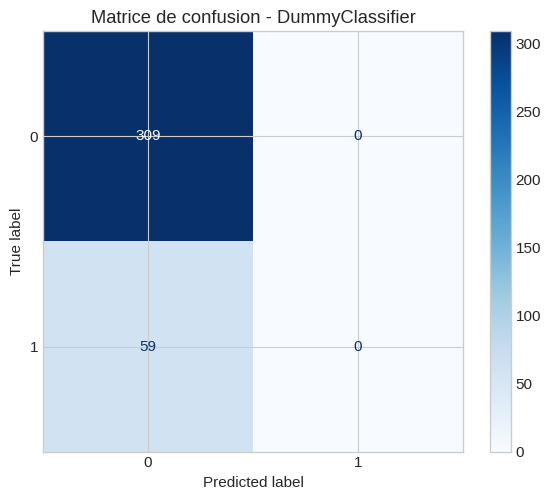

{'accuracy': np.float64(0.8396739130434783),
 'f1_class1': np.float64(0.0),
 'precision_class1': np.float64(0.0),
 'recall_class1': np.float64(0.0),
 'confusion_matrix': array([[309,   0],
        [ 59,   0]])}

In [30]:
# ============================================================
# DUMMY CLASSIFIER (Baseline naïf)
# ============================================================
# Prédit toujours la classe majoritaire - sert de référence "zéro effort"

dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)

evaluate_model(dummy, "DummyClassifier", X_train, y_train, X_test, y_test)


📊 Modèle : LogisticRegression

--- Sur le jeu TRAIN ---
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       924
           1       0.43      0.80      0.56       178

    accuracy                           0.80      1102
   macro avg       0.69      0.80      0.72      1102
weighted avg       0.87      0.80      0.82      1102


--- Sur le jeu TEST ---
              precision    recall  f1-score   support

           0       0.92      0.83      0.88       309
           1       0.43      0.64      0.51        59

    accuracy                           0.80       368
   macro avg       0.68      0.74      0.70       368
weighted avg       0.84      0.80      0.82       368



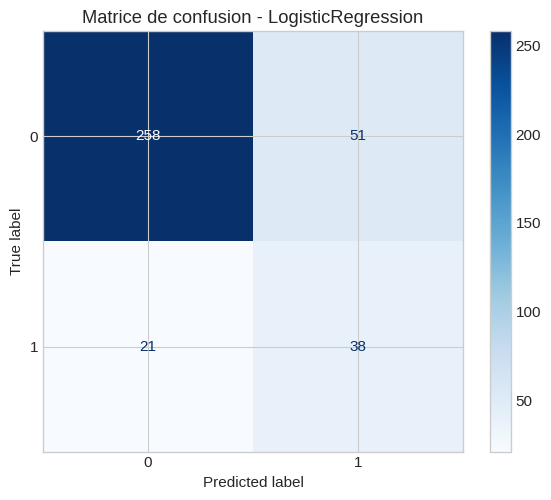

{'accuracy': np.float64(0.8043478260869565),
 'f1_class1': np.float64(0.5135135135135135),
 'precision_class1': np.float64(0.42696629213483145),
 'recall_class1': np.float64(0.6440677966101694),
 'confusion_matrix': array([[258,  51],
        [ 21,  38]])}

In [31]:
# ============================================================
# LOGISTIC REGRESSION (Baseline intelligent)
# ============================================================
# Modèle linéaire simple mais souvent efficace

logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Gestion du déséquilibre
    random_state=RANDOM_STATE
)
logreg.fit(X_train, y_train)

evaluate_model(logreg, "LogisticRegression", X_train, y_train, X_test, y_test)

## 4.3 Modèles Ensemblistes

Entraînement de modèles plus complexes avec optimisation des hyperparamètres.

### 4.3.1 Random Forest

In [32]:
# ============================================================
# RANDOM FOREST avec GridSearchCV
# ============================================================

rf_param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [4, 6, 8, 10, None],
    'min_samples_leaf': [2, 4, 6],
    'class_weight': ['balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy']
}

rf_base = RandomForestClassifier(random_state=RANDOM_STATE)

print("🔍 GridSearchCV RandomForest en cours...")
rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    scoring=F1_SCORER,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"\n✅ Meilleurs paramètres : {rf_grid.best_params_}")
print(f"📈 Meilleur F1 (CV) : {rf_grid.best_score_:.2%}")

best_rf = rf_grid.best_estimator_

🔍 GridSearchCV RandomForest en cours...
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

✅ Meilleurs paramètres : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'n_estimators': 50}
📈 Meilleur F1 (CV) : 52.84%



📊 Modèle : RandomForest

--- Sur le jeu TRAIN ---
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       924
           1       0.83      0.93      0.88       178

    accuracy                           0.96      1102
   macro avg       0.91      0.95      0.93      1102
weighted avg       0.96      0.96      0.96      1102


--- Sur le jeu TEST ---
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       309
           1       0.39      0.24      0.29        59

    accuracy                           0.82       368
   macro avg       0.63      0.58      0.60       368
weighted avg       0.79      0.82      0.80       368



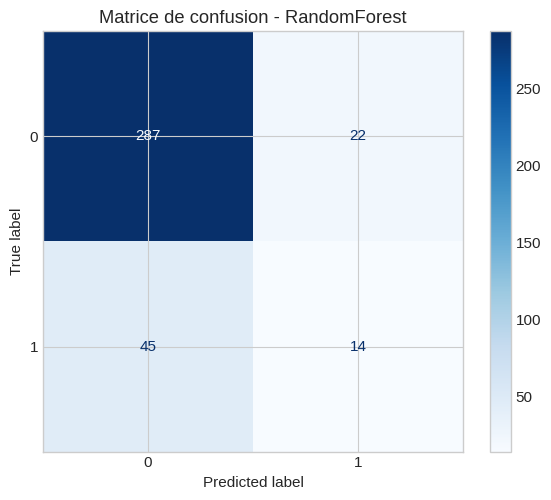

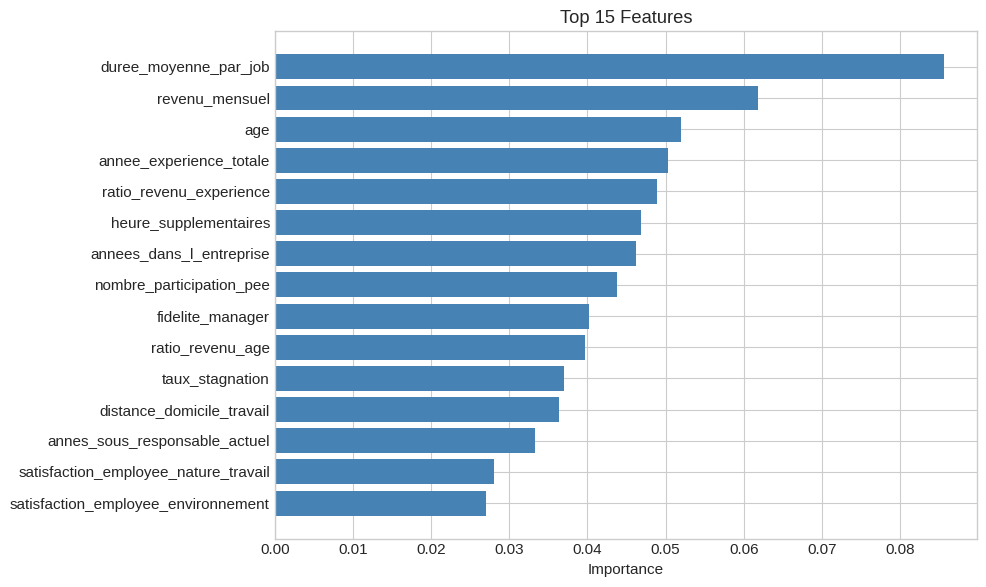

,feature,importance
23,duree_moyenne_par_job,0.085561
1,revenu_mensuel,0.061791
0,age,0.052020
3,annee_experience_totale,0.050291
19,ratio_revenu_experience,0.048930
27,heure_supplementaires,0.046895
4,annees_dans_l_entreprise,0.046164
13,nombre_participation_pee,0.043788
22,fidelite_manager,0.040168
20,ratio_revenu_age,0.039642


In [33]:
# Évaluation du meilleur RandomForest
evaluate_model(best_rf, "RandomForest", X_train, y_train, X_test, y_test)

# Feature importance
get_feature_importance(best_rf, X_train.columns)

### 4.3.2 Gradient Boosting

In [34]:
# ============================================================
# GRADIENT BOOSTING avec GridSearchCV
# ============================================================
# Note: GradientBoosting n'a pas de class_weight, on utilise sample_weight

# Calcul des poids d'échantillon pour le déséquilibre
sample_weights = np.where(y_train == 1, class_weights[1], class_weights[0])

gbc_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_leaf': [2, 5, 10]
}

gbc_base = GradientBoostingClassifier(random_state=RANDOM_STATE)

print("🔍 GridSearchCV GradientBoosting en cours...")
gbc_grid = GridSearchCV(
    estimator=gbc_base,
    param_grid=gbc_param_grid,
    scoring=F1_SCORER,
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

# Entraînement avec sample_weight
gbc_grid.fit(X_train, y_train, sample_weight=sample_weights)

print(f"\n✅ Meilleurs paramètres : {gbc_grid.best_params_}")
print(f"📈 Meilleur F1 (CV) : {gbc_grid.best_score_:.2%}")

best_gbc = gbc_grid.best_estimator_

🔍 GridSearchCV GradientBoosting en cours...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 10, 'n_estimators': 150}
📈 Meilleur F1 (CV) : 53.10%



📊 Modèle : GradientBoosting

--- Sur le jeu TRAIN ---
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       924
           1       0.83      0.99      0.90       178

    accuracy                           0.97      1102
   macro avg       0.91      0.97      0.94      1102
weighted avg       0.97      0.97      0.97      1102


--- Sur le jeu TEST ---
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       309
           1       0.48      0.53      0.50        59

    accuracy                           0.83       368
   macro avg       0.69      0.71      0.70       368
weighted avg       0.84      0.83      0.83       368



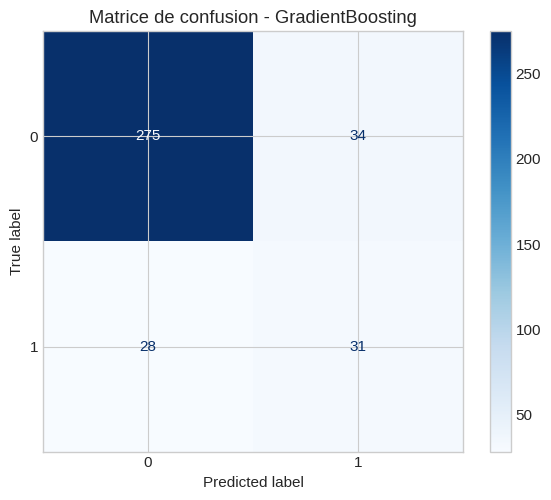

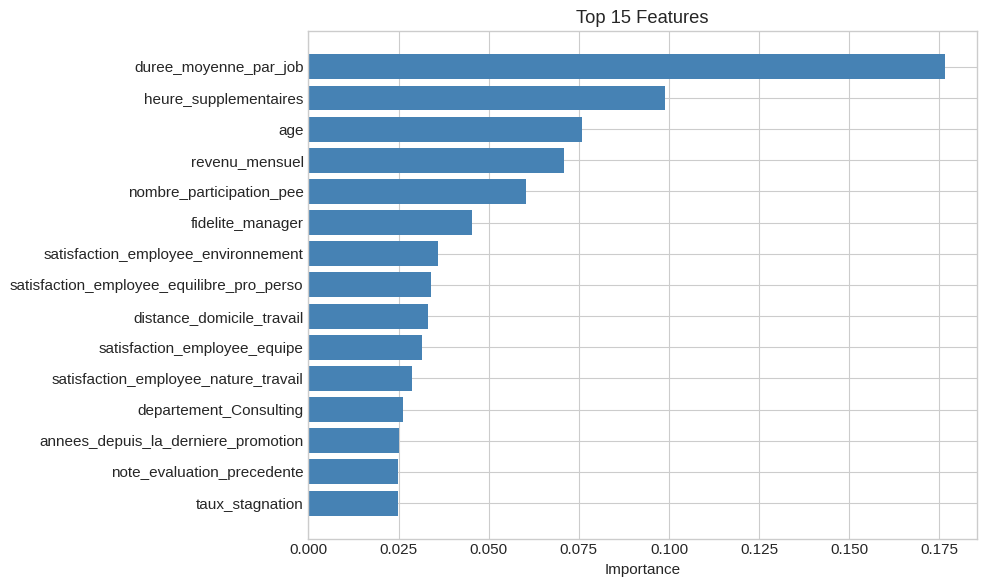

,feature,importance
23,duree_moyenne_par_job,0.176575
27,heure_supplementaires,0.098816
0,age,0.075835
1,revenu_mensuel,0.070958
13,nombre_participation_pee,0.060364
22,fidelite_manager,0.045294
6,satisfaction_employee_environnement,0.036081
11,satisfaction_employee_equilibre_pro_perso,0.034084
15,distance_domicile_travail,0.033204
10,satisfaction_employee_equipe,0.031540


In [35]:
# Évaluation du meilleur GradientBoosting
evaluate_model(best_gbc, "GradientBoosting", X_train, y_train, X_test, y_test)

# Feature importance
get_feature_importance(best_gbc, X_train.columns)

### 4.3.3 XGBoost

In [36]:
# ============================================================
# XGBOOST avec GridSearchCV
# ============================================================

# Calcul du ratio de déséquilibre pour XGBoost
scale_pos_weight = ((y_train == 0).sum() / (y_train == 1).sum())
print(f"📊 Ratio de déséquilibre (scale_pos_weight) : {scale_pos_weight:.2f}")

xgb_param_grid = {
    'n_estimators': [20,50,100, 200, 300],
    'max_depth': [3, 5, 7,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=RANDOM_STATE
)

print("🔍 GridSearchCV XGBoost en cours...")
xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    scoring='f1',
    cv=CV_FOLDS,
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

print(f"\n✅ Meilleurs paramètres : {xgb_grid.best_params_}")
print(f"📈 Meilleur F1 (CV) : {xgb_grid.best_score_:.2%}")

best_xgb = xgb_grid.best_estimator_

📊 Ratio de déséquilibre (scale_pos_weight) : 5.19
🔍 GridSearchCV XGBoost en cours...
Fitting 5 folds for each of 240 candidates, totalling 1200 fits

✅ Meilleurs paramètres : {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
📈 Meilleur F1 (CV) : 54.94%



📊 Modèle : XGBoost

--- Sur le jeu TRAIN ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       924
           1       0.90      1.00      0.95       178

    accuracy                           0.98      1102
   macro avg       0.95      0.99      0.97      1102
weighted avg       0.98      0.98      0.98      1102


--- Sur le jeu TEST ---
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       309
           1       0.57      0.46      0.51        59

    accuracy                           0.86       368
   macro avg       0.74      0.70      0.71       368
weighted avg       0.85      0.86      0.85       368



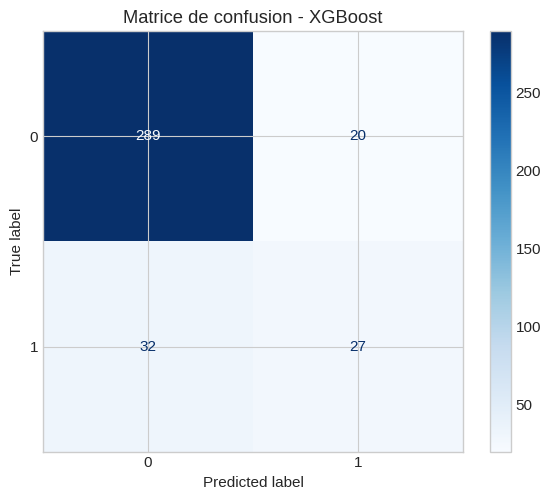

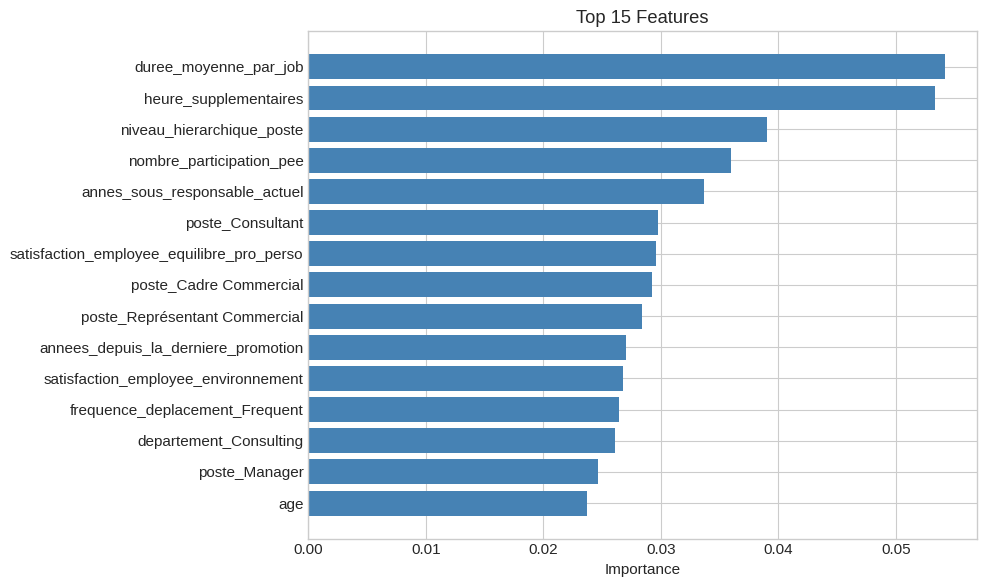

,feature,importance
23,duree_moyenne_par_job,0.054191
27,heure_supplementaires,0.053330
8,niveau_hierarchique_poste,0.039069
13,nombre_participation_pee,0.035985
18,annes_sous_responsable_actuel,0.033700
33,poste_Consultant,0.029790
11,satisfaction_employee_equilibre_pro_perso,0.029590
32,poste_Cadre Commercial,0.029214
36,poste_Représentant Commercial,0.028411
17,annees_depuis_la_derniere_promotion,0.027034


In [37]:
# Évaluation du meilleur XGBoost
evaluate_model(best_xgb, "XGBoost", X_train, y_train, X_test, y_test)

# Feature importance
get_feature_importance(best_xgb, X_train.columns)

## 4.4 Benchmark & Comparaison

Comparaison globale de tous les modèles entraînés.

In [38]:
# ============================================================
# TABLEAU COMPARATIF
# ============================================================

df_comparison = compare_models_table(models_results)

# Affichage avec style
styled_comparison = (df_comparison.style
    .background_gradient(cmap='Greens', subset=['F1 (Classe 1)', 'Recall (Classe 1)'])
    .background_gradient(cmap='Reds', subset=['FP', 'FN'])
    .format("{:.2%}", subset=['Accuracy', 'F1 (Classe 1)', 'Precision (Classe 1)', 'Recall (Classe 1)'])
    .set_caption("📊 Comparaison des performances des modèles (Trié par F1)")
)

styled_comparison

,Modèle,Accuracy,F1 (Classe 1),Precision (Classe 1),Recall (Classe 1),TP,FP,TN,FN
1,LogisticRegression,80.43%,51.35%,42.70%,64.41%,38,51,258,21
4,XGBoost,85.87%,50.94%,57.45%,45.76%,27,20,289,32
3,GradientBoosting,83.15%,50.00%,47.69%,52.54%,31,34,275,28
2,RandomForest,81.79%,29.47%,38.89%,23.73%,14,22,287,45
0,DummyClassifier,83.97%,0.00%,0.00%,0.00%,0,0,309,59


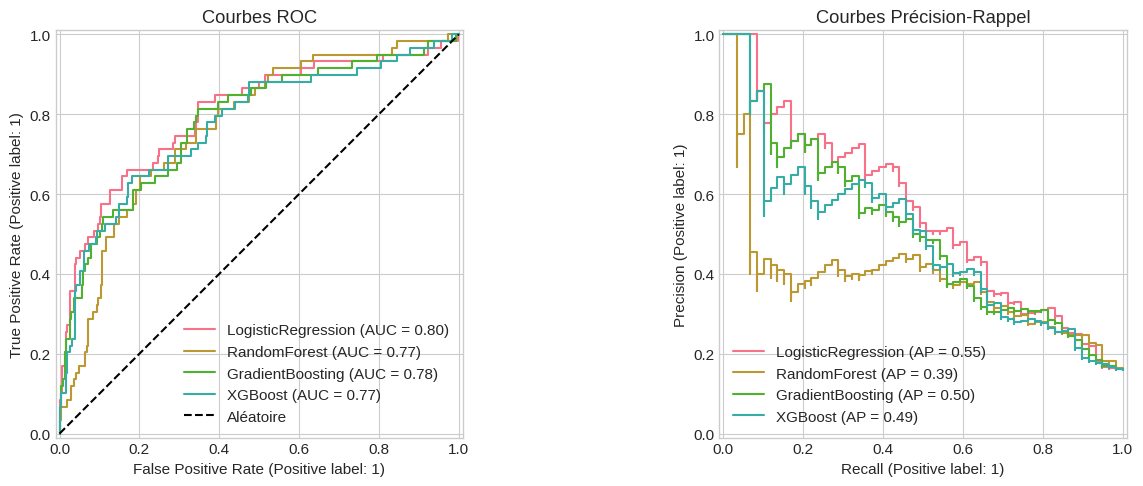

In [39]:
# ============================================================
# COURBES ROC & PRECISION-RECALL
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Liste des modèles avec proba
models_to_plot = [
    ("LogisticRegression", logreg),
    ("RandomForest", best_rf),
    ("GradientBoosting", best_gbc),
    ("XGBoost", best_xgb)
]

# ROC Curves
for name, model in models_to_plot:
    if hasattr(model, 'predict_proba'):
        RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0], name=name)

axes[0].set_title('Courbes ROC')
axes[0].plot([0, 1], [0, 1], 'k--', label='Aléatoire')
axes[0].legend(loc='lower right')

# Precision-Recall Curves
for name, model in models_to_plot:
    if hasattr(model, 'predict_proba'):
        PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[1], name=name)

axes[1].set_title('Courbes Précision-Rappel')
axes[1].legend(loc='lower left')

plt.tight_layout()
plt.show()

## 4.5 Optimisation du Seuil de Décision

Par défaut, un classificateur utilise un seuil de 0.5. En ajustant ce seuil, on peut optimiser le compromis Précision/Rappel selon le contexte métier.

In [40]:
# ============================================================
# RECHERCHE DU SEUIL OPTIMAL
# ============================================================

# On utilise le meilleur modèle (XGBoost en général)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Test de différents seuils
thresholds = np.arange(0.1, 0.9, 0.05)
results_threshold = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)

    results_threshold.append({
        'seuil': t,
        'precision': precision_score(y_test, y_pred_t, zero_division=0),
        'recall': recall_score(y_test, y_pred_t),
        'f1': f1_score(y_test, y_pred_t)
    })

df_thresholds = pd.DataFrame(results_threshold)

# Trouver le seuil optimal (F1 max)
best_idx = df_thresholds['f1'].idxmax()
OPTIMAL_THRESHOLD = df_thresholds.loc[best_idx, 'seuil']

print(f"🏆 Seuil optimal trouvé : {OPTIMAL_THRESHOLD:.2f}")
print(f"   F1-Score : {df_thresholds.loc[best_idx, 'f1']:.2%}")
print(f"   Precision : {df_thresholds.loc[best_idx, 'precision']:.2%}")
print(f"   Recall : {df_thresholds.loc[best_idx, 'recall']:.2%}")

🏆 Seuil optimal trouvé : 0.50
   F1-Score : 50.94%
   Precision : 57.45%
   Recall : 45.76%


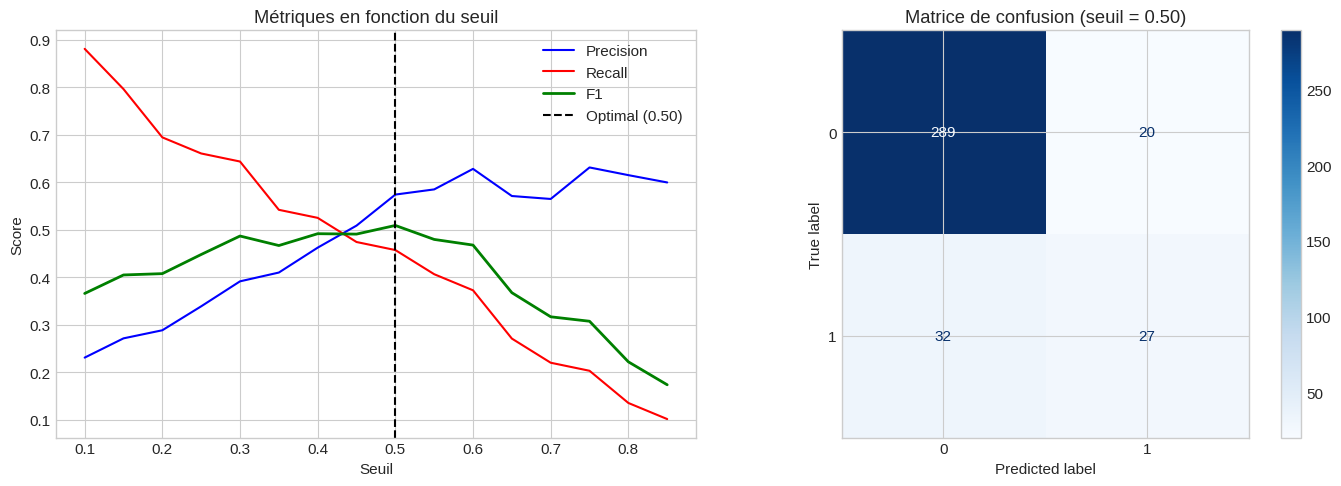


📊 Comparaison seuil 0.5 vs optimal :
Métrique        Seuil 0.5    Seuil optimal Δ         
--------------------------------------------------
Precision       57.45%     57.45%     +0.00%
Recall          45.76%     45.76%     +0.00%
F1              50.94%     50.94%     +0.00%


In [41]:
# Visualisation de l'impact du seuil
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Courbe Precision/Recall vs Seuil
axes[0].plot(df_thresholds['seuil'], df_thresholds['precision'], label='Precision', color='blue')
axes[0].plot(df_thresholds['seuil'], df_thresholds['recall'], label='Recall', color='red')
axes[0].plot(df_thresholds['seuil'], df_thresholds['f1'], label='F1', color='green', linewidth=2)
axes[0].axvline(OPTIMAL_THRESHOLD, color='black', linestyle='--', label=f'Optimal ({OPTIMAL_THRESHOLD:.2f})')
axes[0].set_xlabel('Seuil')
axes[0].set_ylabel('Score')
axes[0].set_title('Métriques en fonction du seuil')
axes[0].legend()
axes[0].grid(True)

# Comparaison matrices de confusion
y_pred_default = best_xgb.predict(X_test)
y_pred_optimal = (y_proba >= OPTIMAL_THRESHOLD).astype(int)

# Subplot pour matrice avec seuil optimal
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_optimal, ax=axes[1], cmap='Blues')
axes[1].set_title(f'Matrice de confusion (seuil = {OPTIMAL_THRESHOLD:.2f})')

plt.tight_layout()
plt.show()

# Comparaison chiffrée
print("\n📊 Comparaison seuil 0.5 vs optimal :")
print(f"{'Métrique':<15} {'Seuil 0.5':<12} {'Seuil optimal':<12} {'Δ':<10}")
print("-" * 50)

for metric, func in [('Precision', precision_score), ('Recall', recall_score), ('F1', f1_score)]:
    val_05 = func(y_test, y_pred_default)
    val_opt = func(y_test, y_pred_optimal)
    print(f"{metric:<15} {val_05:.2%}{'':>4} {val_opt:.2%}{'':>4} {val_opt - val_05:+.2%}")

## 4.6 Bilan Modélisation

### 📊 Résumé des performances

In [42]:
# ============================================================
# BILAN MODÉLISATION
# ============================================================

# Sélection du meilleur modèle
best_model_name = df_comparison.iloc[0]['Modèle']
best_model = models_results[best_model_name]['model']

print("=" * 60)
print("🏆 BILAN DE LA MODÉLISATION")
print("=" * 60)

print(f"\n📌 Meilleur modèle : {best_model_name}")
print(f"   - F1 (Classe Démission) : {df_comparison.iloc[0]['F1 (Classe 1)']:.2%}")
print(f"   - Recall : {df_comparison.iloc[0]['Recall (Classe 1)']:.2%}")
print(f"   - Precision : {df_comparison.iloc[0]['Precision (Classe 1)']:.2%}")

print(f"\n📌 Seuil de décision optimal : {OPTIMAL_THRESHOLD:.2f}")

# Résumé matrice de confusion
cm = models_results[best_model_name]['metrics']['confusion_matrix']
tn, fp, fn, tp = cm.ravel()

print(f"\n📌 Sur le jeu de test ({len(y_test)} observations) :")
print(f"   - Vrais Positifs (démissions détectées) : {tp}")
print(f"   - Faux Négatifs (démissions ratées) : {fn}")
print(f"   - Faux Positifs (fausses alertes) : {fp}")
print(f"   - Vrais Négatifs (restés correctement prédits) : {tn}")

print("\n" + "=" * 60)
print("✅ Le modèle est prêt pour l'interprétation SHAP")
print("=" * 60)

🏆 BILAN DE LA MODÉLISATION

📌 Meilleur modèle : LogisticRegression
   - F1 (Classe Démission) : 51.35%
   - Recall : 64.41%
   - Precision : 42.70%

📌 Seuil de décision optimal : 0.50

📌 Sur le jeu de test (368 observations) :
   - Vrais Positifs (démissions détectées) : 38
   - Faux Négatifs (démissions ratées) : 21
   - Faux Positifs (fausses alertes) : 51
   - Vrais Négatifs (restés correctement prédits) : 258

✅ Le modèle est prêt pour l'interprétation SHAP


# 5. Interprétabilité avec SHAP 🔍

**Objectif :** Comprendre *pourquoi* le modèle prédit une démission pour expliquer ses décisions aux RH.

**SHAP (SHapley Additive exPlanations)** permet de :
- Identifier les **facteurs clés** de démission (globalement)
- Expliquer **chaque prédiction individuelle**
- Détecter les **interactions** entre variables
- Analyser les **erreurs** du modèle (FP, FN)

> 💡 **Valeur métier** : Transformer un modèle "boîte noire" en outil d'aide à la décision actionnable pour les RH.

## 5.1 Configuration SHAP

In [43]:
# ============================================================
# CONFIGURATION SHAP
# ============================================================

import shap

# Création de l'explainer pour le meilleur modèle (XGBoost)
print("🔄 Création de l'explainer SHAP...")
explainer = shap.TreeExplainer(best_xgb)

# Calcul des SHAP values sur le jeu de test
print("🔄 Calcul des SHAP values...")
shap_values = explainer.shap_values(X_test)

# Gestion du format (binaire vs multiclasse)
if isinstance(shap_values, list):
    # Format liste : [classe_0, classe_1]
    shap_values_class1 = shap_values[1]
elif len(shap_values.shape) == 3:
    # Format 3D : (samples, features, classes)
    shap_values_class1 = shap_values[:, :, 1]
else:
    # Format 2D standard
    shap_values_class1 = shap_values

print(f"✅ SHAP values calculées : {shap_values_class1.shape}")
print(f"   - Observations : {shap_values_class1.shape[0]}")
print(f"   - Features : {shap_values_class1.shape[1]}")

🔄 Création de l'explainer SHAP...
🔄 Calcul des SHAP values...
✅ SHAP values calculées : (368, 47)
   - Observations : 368
   - Features : 47


## 5.2 Analyse Globale des Features

Quels facteurs influencent le plus la prédiction de démission ?

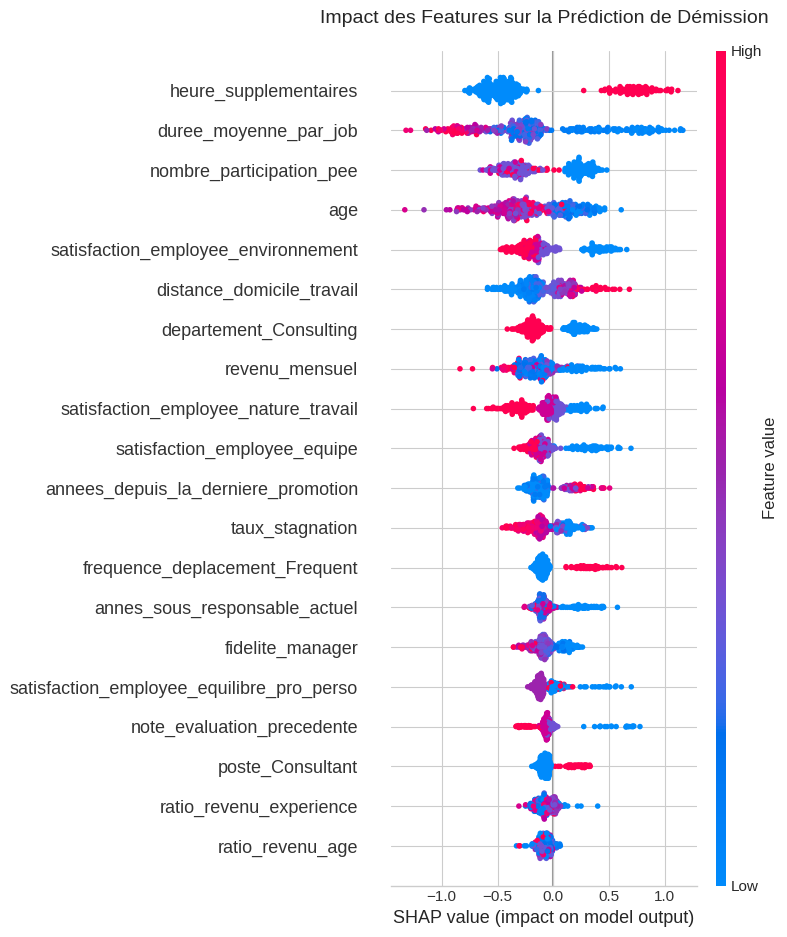

In [44]:
# ============================================================
# SUMMARY PLOT (Beeswarm) - Impact détaillé de chaque feature
# ============================================================
# Chaque point = une observation
# Position horizontale = impact SHAP (négatif = pousse vers "reste", positif = pousse vers "démission")
# Couleur = valeur de la feature (bleu = basse, rouge = haute)

plt.figure(figsize=(12, 8))
plt.title("Impact des Features sur la Prédiction de Démission", fontsize=14, pad=20)
shap.summary_plot(shap_values_class1, X_test, show=False, max_display=20)
plt.tight_layout()
plt.show()

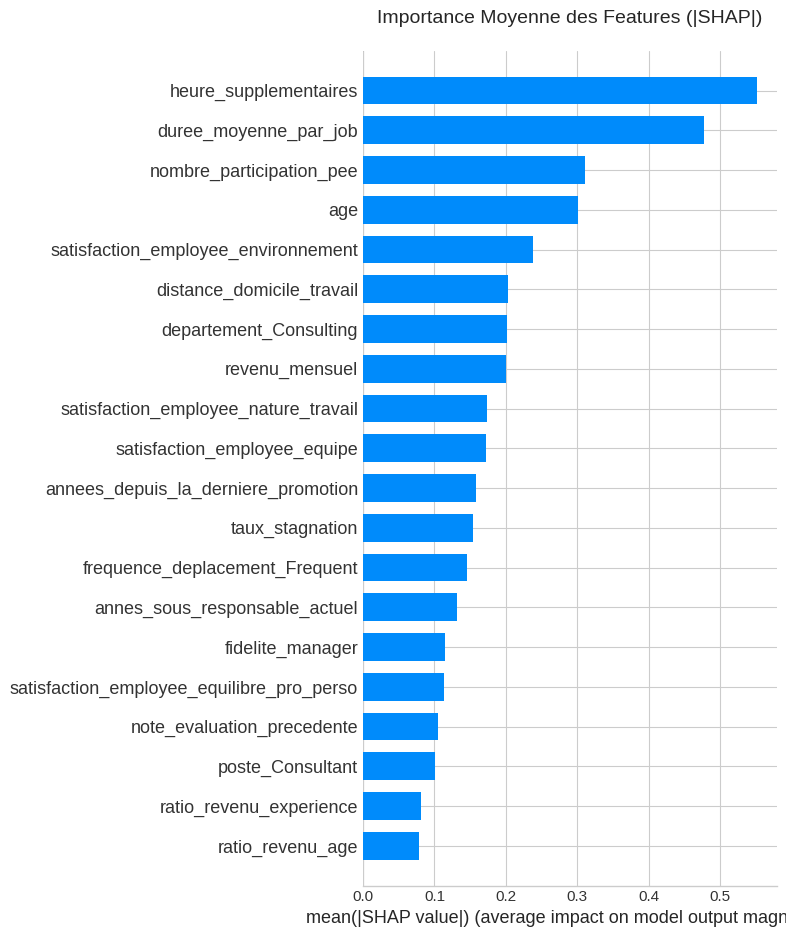


📊 Top 10 Features par Importance SHAP :
                             feature  importance
               heure_supplementaires    0.552199
               duree_moyenne_par_job    0.477149
            nombre_participation_pee    0.310249
                                 age    0.301635
 satisfaction_employee_environnement    0.237369
           distance_domicile_travail    0.202495
              departement_Consulting    0.201414
                      revenu_mensuel    0.199575
satisfaction_employee_nature_travail    0.173015
        satisfaction_employee_equipe    0.172509


In [45]:
# ============================================================
# BAR PLOT - Importance moyenne de chaque feature
# ============================================================

plt.figure(figsize=(12, 8))
plt.title("Importance Moyenne des Features (|SHAP|)", fontsize=14, pad=20)
shap.summary_plot(shap_values_class1, X_test, plot_type="bar", show=False, max_display=20)
plt.tight_layout()
plt.show()

# Extraction du top 10 pour référence
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values_class1).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 Features par Importance SHAP :")
print(shap_importance.head(10).to_string(index=False))

## 5.3 Analyse par Groupe de Prédiction

Comparaison des facteurs entre Vrais Positifs, Faux Positifs et Faux Négatifs pour comprendre les erreurs du modèle.

In [46]:
# ============================================================
# CRÉATION DES MASQUES PAR GROUPE
# ============================================================

# Prédictions avec le seuil optimal
y_pred_optimal = (best_xgb.predict_proba(X_test)[:, 1] >= OPTIMAL_THRESHOLD).astype(int)
y_test_array = y_test.values if hasattr(y_test, 'values') else np.array(y_test)

# Masques
mask_tp = (y_pred_optimal == 1) & (y_test_array == 1)  # Vrais Positifs (démissions détectées)
mask_fp = (y_pred_optimal == 1) & (y_test_array == 0)  # Faux Positifs (fausses alertes)
mask_fn = (y_pred_optimal == 0) & (y_test_array == 1)  # Faux Négatifs (démissions ratées)
mask_tn = (y_pred_optimal == 0) & (y_test_array == 0)  # Vrais Négatifs

print("📊 Répartition des prédictions :")
print(f"   - Vrais Positifs (TP) : {mask_tp.sum()} - Démissions correctement détectées")
print(f"   - Faux Positifs (FP) : {mask_fp.sum()} - Fausses alertes")
print(f"   - Faux Négatifs (FN) : {mask_fn.sum()} - Démissions ratées")
print(f"   - Vrais Négatifs (TN) : {mask_tn.sum()} - Restés correctement prédits")

📊 Répartition des prédictions :
   - Vrais Positifs (TP) : 27 - Démissions correctement détectées
   - Faux Positifs (FP) : 20 - Fausses alertes
   - Faux Négatifs (FN) : 32 - Démissions ratées
   - Vrais Négatifs (TN) : 289 - Restés correctement prédits


🎯 VRAIS POSITIFS - Facteurs des démissions réelles détectées


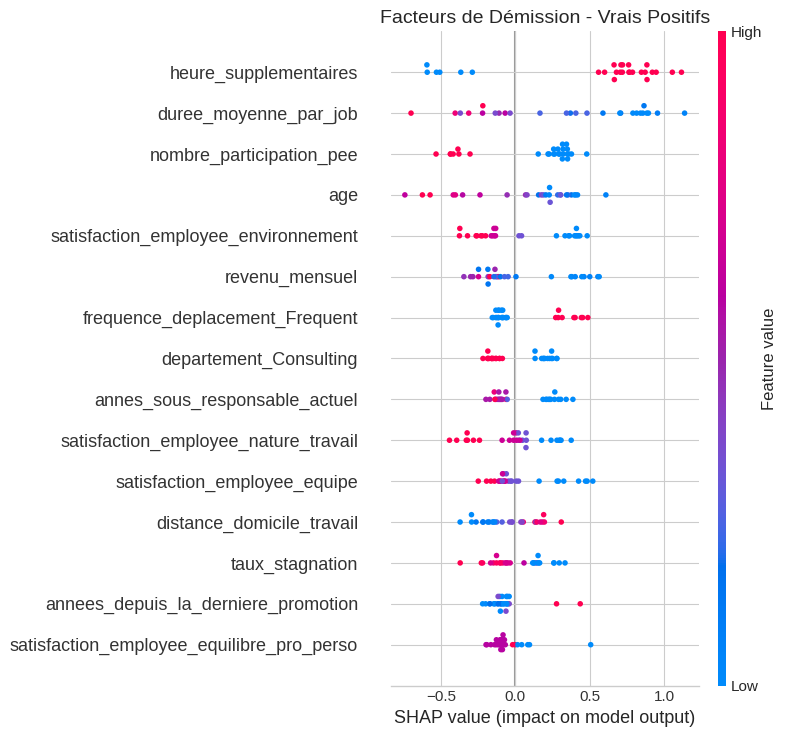

In [47]:
# ============================================================
# ANALYSE DES VRAIS POSITIFS (Causes réelles de démission)
# ============================================================

if mask_tp.sum() > 0:
    print("="*60)
    print("🎯 VRAIS POSITIFS - Facteurs des démissions réelles détectées")
    print("="*60)

    shap_tp = shap_values_class1[mask_tp]
    X_tp = X_test[mask_tp]

    plt.figure(figsize=(12, 6))
    plt.title("Facteurs de Démission - Vrais Positifs", fontsize=14)
    shap.summary_plot(shap_tp, X_tp, show=False, max_display=15)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Aucun Vrai Positif dans le jeu de test")

⚠️ FAUX POSITIFS - Pourquoi le modèle s'est trompé


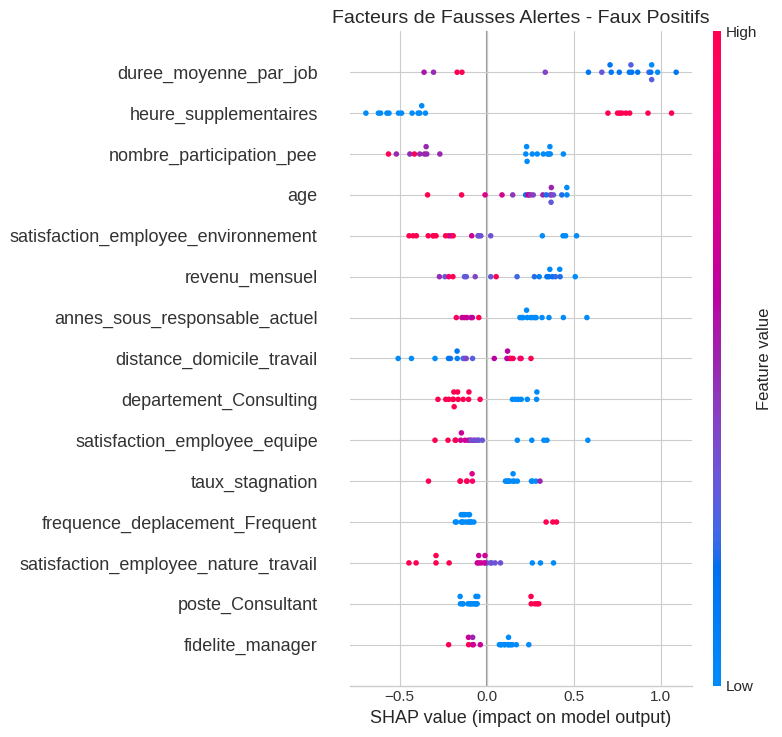


📋 Détail des premiers Faux Positifs :

--- Faux Positif #1 (ID: 670) ---
  duree_moyenne_par_job: SHAP=+1.088 (↑ Démission) | Valeur=-0.93
  heure_supplementaires: SHAP=-0.694 (↓ Reste) | Valeur=0.00
  age: SHAP=+0.366 (↑ Démission) | Valeur=-1.08
  nombre_participation_pee: SHAP=+0.325 (↑ Démission) | Valeur=-0.93
  departement_Consulting: SHAP=-0.280 (↓ Reste) | Valeur=1.00

--- Faux Positif #2 (ID: 764) ---
  duree_moyenne_par_job: SHAP=+0.867 (↑ Démission) | Valeur=-0.93
  revenu_mensuel: SHAP=+0.419 (↑ Démission) | Valeur=-1.18
  heure_supplementaires: SHAP=-0.394 (↓ Reste) | Valeur=0.00
  nombre_participation_pee: SHAP=+0.365 (↑ Démission) | Valeur=-0.93
  age: SHAP=+0.322 (↑ Démission) | Valeur=-0.97

--- Faux Positif #3 (ID: 1402) ---
  duree_moyenne_par_job: SHAP=+0.819 (↑ Démission) | Valeur=-0.93
  heure_supplementaires: SHAP=+0.751 (↑ Démission) | Valeur=1.00
  revenu_mensuel: SHAP=+0.508 (↑ Démission) | Valeur=-1.16
  note_evaluation_precedente: SHAP=+0.463 (↑ Démission) 

In [48]:
# ============================================================
# ANALYSE DES FAUX POSITIFS (Comprendre les fausses alertes)
# ============================================================

if mask_fp.sum() > 0:
    print("="*60)
    print("⚠️ FAUX POSITIFS - Pourquoi le modèle s'est trompé")
    print("="*60)

    shap_fp = shap_values_class1[mask_fp]
    X_fp = X_test[mask_fp]

    plt.figure(figsize=(12, 6))
    plt.title("Facteurs de Fausses Alertes - Faux Positifs", fontsize=14)
    shap.summary_plot(shap_fp, X_fp, show=False, max_display=15)
    plt.tight_layout()
    plt.show()

    # Détail des 3 premiers FP
    print("\n📋 Détail des premiers Faux Positifs :")
    fp_indices = X_test[mask_fp].index[:3]
    for i, idx in enumerate(fp_indices):
        print(f"\n--- Faux Positif #{i+1} (ID: {idx}) ---")
        row_idx = X_test.index.get_loc(idx)
        top_features_idx = np.argsort(np.abs(shap_values_class1[row_idx]))[::-1][:5]
        for feat_idx in top_features_idx:
            feat_name = X_test.columns[feat_idx]
            shap_val = shap_values_class1[row_idx, feat_idx]
            feat_val = X_test.iloc[row_idx, feat_idx]
            direction = "↑ Démission" if shap_val > 0 else "↓ Reste"
            print(f"  {feat_name}: SHAP={shap_val:+.3f} ({direction}) | Valeur={feat_val:.2f}")
else:
    print("✅ Aucun Faux Positif - Le modèle ne génère pas de fausses alertes")

❌ FAUX NÉGATIFS - Démissionnaires non détectés


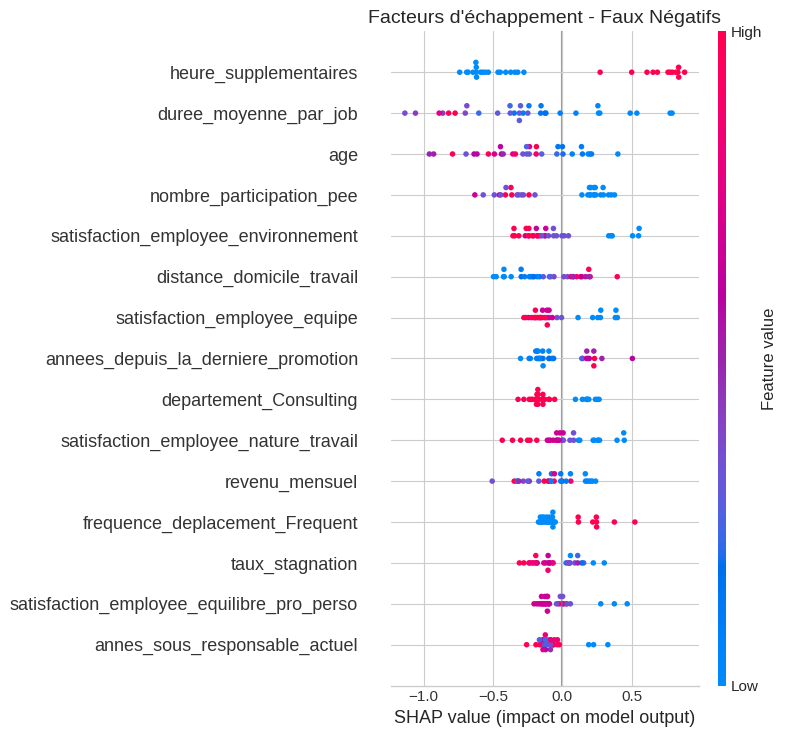


📋 Détail des premiers Faux Négatifs :

--- Faux Négatif #1 (ID: 239) ---
  heure_supplementaires: SHAP=+0.882 (↑ Démission) | Valeur=1.00
  distance_domicile_travail: SHAP=-0.496 (↓ Reste) | Valeur=-1.02
  satisfaction_employee_equilibre_pro_perso: SHAP=+0.468 (↑ Démission) | Valeur=-2.46
  nombre_experiences_precedentes: SHAP=-0.400 (↓ Reste) | Valeur=-1.08
  duree_moyenne_par_job: SHAP=-0.377 (↓ Reste) | Valeur=-0.04

--- Faux Négatif #2 (ID: 122) ---
  heure_supplementaires: SHAP=+0.654 (↑ Démission) | Valeur=1.00
  age: SHAP=-0.533 (↓ Reste) | Valeur=2.08
  revenu_mensuel: SHAP=-0.505 (↓ Reste) | Valeur=-0.33
  nombre_participation_pee: SHAP=-0.364 (↓ Reste) | Valeur=2.61
  duree_moyenne_par_job: SHAP=+0.270 (↑ Démission) | Valeur=-0.88

--- Faux Négatif #3 (ID: 126) ---
  duree_moyenne_par_job: SHAP=-0.773 (↓ Reste) | Valeur=4.01
  nombre_participation_pee: SHAP=-0.294 (↓ Reste) | Valeur=0.25
  heure_supplementaires: SHAP=-0.277 (↓ Reste) | Valeur=0.00
  annees_depuis_la_derniere

In [49]:
# ============================================================
# ANALYSE DES FAUX NÉGATIFS (Démissionnaires non détectés)
# ============================================================

if mask_fn.sum() > 0:
    print("="*60)
    print("❌ FAUX NÉGATIFS - Démissionnaires non détectés")
    print("="*60)

    shap_fn = shap_values_class1[mask_fn]
    X_fn = X_test[mask_fn]

    plt.figure(figsize=(12, 6))
    plt.title("Facteurs d'échappement - Faux Négatifs", fontsize=14)
    shap.summary_plot(shap_fn, X_fn, show=False, max_display=15)
    plt.tight_layout()
    plt.show()

    # Détail des 3 premiers FN
    print("\n📋 Détail des premiers Faux Négatifs :")
    fn_indices = X_test[mask_fn].index[:3]
    for i, idx in enumerate(fn_indices):
        print(f"\n--- Faux Négatif #{i+1} (ID: {idx}) ---")
        row_idx = X_test.index.get_loc(idx)
        top_features_idx = np.argsort(np.abs(shap_values_class1[row_idx]))[::-1][:5]
        for feat_idx in top_features_idx:
            feat_name = X_test.columns[feat_idx]
            shap_val = shap_values_class1[row_idx, feat_idx]
            feat_val = X_test.iloc[row_idx, feat_idx]
            direction = "↑ Démission" if shap_val > 0 else "↓ Reste"
            print(f"  {feat_name}: SHAP={shap_val:+.3f} ({direction}) | Valeur={feat_val:.2f}")

    print("\n💡 INSIGHT: Ces employés ont démissionné malgré des signaux faibles.")
    print("   → Possibles facteurs non capturés dans les données")
else:
    print("🎯 Aucun Faux Négatif - Tous les démissionnaires ont été détectés")

📊 COMPARAISON : Vrais Positifs vs Faux Positifs

🔍 Features plus importantes pour les Vrais Positifs (bonnes détections):
                                      Vrais Positifs  Faux Positifs  Diff (TP - FP)
heure_supplementaires                       0.723156       0.629264        0.093892
ratio_revenu_age                            0.087604       0.046046        0.041558
age                                         0.324940       0.291443        0.033497
annees_depuis_la_derniere_promotion         0.121029       0.087904        0.033126
frequence_deplacement_Frequent              0.193419       0.161360        0.032059
satisfaction_employee_nature_travail        0.178383       0.149538        0.028845
niveau_education                            0.053435       0.027829        0.025606
nombre_experiences_precedentes              0.036229       0.014742        0.021487
niveau_hierarchique_poste                   0.048585       0.034932        0.013653
annees_dans_le_poste_actuel           

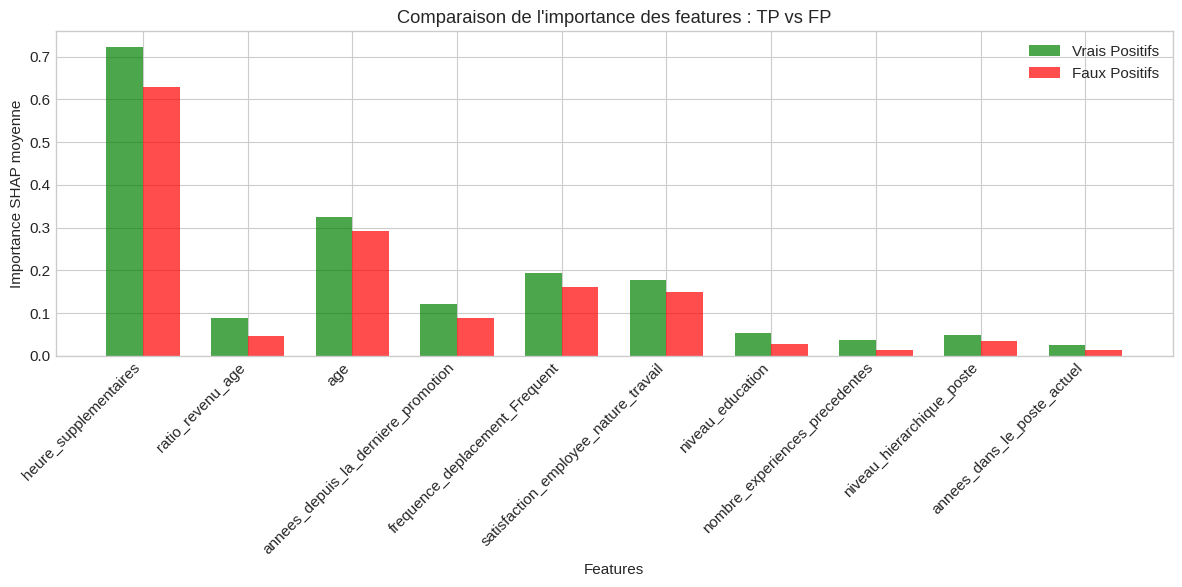

In [50]:
# ============================================================
# COMPARAISON TP vs FP - Qu'est-ce qui distingue les bonnes prédictions ?
# ============================================================

print("="*60)
print("📊 COMPARAISON : Vrais Positifs vs Faux Positifs")
print("="*60)

# Importance moyenne par groupe
def calc_mean_shap(mask, feature_names, shap_values):
    """Calcule l'importance SHAP moyenne pour un groupe"""
    if mask.sum() == 0:
        return pd.Series(0, index=feature_names)
    return pd.Series(
        np.abs(shap_values[mask]).mean(axis=0),
        index=feature_names
    )

importance_tp = calc_mean_shap(mask_tp, X_test.columns, shap_values_class1)
importance_fp = calc_mean_shap(mask_fp, X_test.columns, shap_values_class1)

comparison_df = pd.DataFrame({
    'Vrais Positifs': importance_tp,
    'Faux Positifs': importance_fp,
    'Diff (TP - FP)': importance_tp - importance_fp
}).sort_values('Diff (TP - FP)', ascending=False)

print("\n🔍 Features plus importantes pour les Vrais Positifs (bonnes détections):")
print(comparison_df.head(10).to_string())

print("\n⚠️ Features plus importantes pour les Faux Positifs (fausses alertes):")
print(comparison_df.tail(5).to_string())

# Visualisation comparative
fig, ax = plt.subplots(figsize=(12, 6))
top_features = comparison_df.index[:10]
x = np.arange(len(top_features))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df.loc[top_features, 'Vrais Positifs'],
               width, label='Vrais Positifs', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, comparison_df.loc[top_features, 'Faux Positifs'],
               width, label='Faux Positifs', color='red', alpha=0.7)

ax.set_xlabel('Features')
ax.set_ylabel('Importance SHAP moyenne')
ax.set_title('Comparaison de l\'importance des features : TP vs FP')
ax.set_xticks(x)
ax.set_xticklabels(top_features, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

### 5.4 Analyse Individuelle des Prédictions

L'analyse individuelle permet d'expliquer chaque prédiction du modèle de manière détaillée :
- **Waterfall plot** : Décomposition additive de la prédiction
- **Force plot** : Visualisation compacte des contributions

Ces outils sont essentiels pour :
1. **Expliquer aux RH** pourquoi un employé spécifique est à risque
2. **Valider les prédictions** en vérifiant la cohérence des facteurs
3. **Identifier des patterns** récurrents dans les cas individuels


🔴 EXEMPLE 1 : VRAI POSITIF - Démissionnaire correctement détecté

📋 EXPLICATION INDIVIDUELLE - Observation #10

🎯 Base value: 0.256
🎯 Sum SHAP: 3.325
🎯 Prédiction finale (log-odds): 3.580

📊 Top 5 features contributives :
  • duree_moyenne_par_job: -0.93 → SHAP = +0.816 (↑ RISQUE)
  • heure_supplementaires: 1.00 → SHAP = +0.764 (↑ RISQUE)
  • age: -1.96 → SHAP = +0.397 (↑ RISQUE)
  • revenu_mensuel: -0.95 → SHAP = +0.380 (↑ RISQUE)
  • nombre_participation_pee: -0.93 → SHAP = +0.298 (↑ RISQUE)


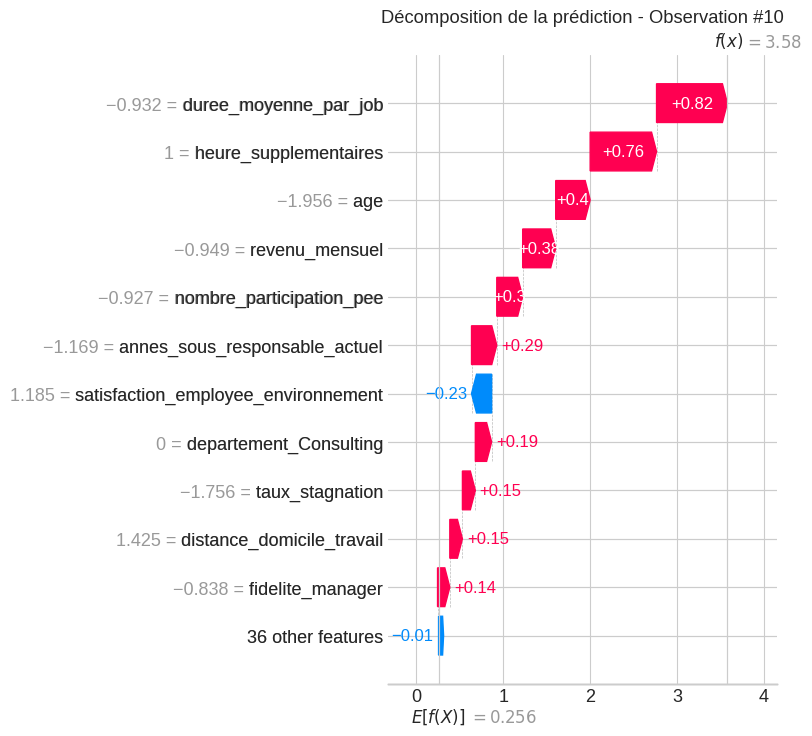

In [51]:
# ============================================================
# 5.4.1 WATERFALL PLOTS - Décomposition des prédictions
# ============================================================

def explain_individual_prediction(idx, shap_values, X_test, explainer, show_waterfall=True):
    """
    Affiche une explication détaillée pour un individu spécifique.

    Parameters:
    -----------
    idx : int
        Position dans X_test (pas l'index pandas)
    shap_values : array
        SHAP values pour la classe positive
    X_test : DataFrame
        Données de test
    explainer : TreeExplainer
        Explainer SHAP
    show_waterfall : bool
        Si True, affiche le waterfall plot
    """
    print(f"\n{'='*60}")
    print(f"📋 EXPLICATION INDIVIDUELLE - Observation #{idx}")
    print(f"{'='*60}")

    # Récupérer les valeurs
    shap_vals = shap_values[idx]
    features = X_test.iloc[idx]
    base_value = explainer.expected_value
    if isinstance(base_value, (list, np.ndarray)):
        base_value = base_value[1] if len(base_value) > 1 else base_value[0]

    # Prédiction
    prediction = base_value + shap_vals.sum()
    print(f"\n🎯 Base value: {base_value:.3f}")
    print(f"🎯 Sum SHAP: {shap_vals.sum():.3f}")
    print(f"🎯 Prédiction finale (log-odds): {prediction:.3f}")

    # Top 5 features contributives
    sorted_idx = np.argsort(np.abs(shap_vals))[::-1]
    print(f"\n📊 Top 5 features contributives :")
    for i in sorted_idx[:5]:
        feat_name = X_test.columns[i]
        shap_val = shap_vals[i]
        feat_val = features.iloc[i]
        direction = "↑ RISQUE" if shap_val > 0 else "↓ STABLE"
        print(f"  • {feat_name}: {feat_val:.2f} → SHAP = {shap_val:+.3f} ({direction})")

    # Waterfall plot
    if show_waterfall:
        shap_exp = shap.Explanation(
            values=shap_vals,
            base_values=base_value,
            data=features.values,
            feature_names=X_test.columns.tolist()
        )
        plt.figure(figsize=(12, 6))
        shap.waterfall_plot(shap_exp, max_display=12, show=False)
        plt.title(f"Décomposition de la prédiction - Observation #{idx}")
        plt.tight_layout()
        plt.show()

# Exemple 1 : Un Vrai Positif (démissionnaire correctement détecté)
print("\n" + "="*70)
print("🔴 EXEMPLE 1 : VRAI POSITIF - Démissionnaire correctement détecté")
print("="*70)
if mask_tp.sum() > 0:
    tp_positions = np.where(mask_tp)[0]
    explain_individual_prediction(tp_positions[0], shap_values_class1, X_test, explainer)
else:
    print("Aucun Vrai Positif disponible")


🟡 EXEMPLE 2 : FAUX POSITIF - Fausse alerte

📋 EXPLICATION INDIVIDUELLE - Observation #8

🎯 Base value: 0.256
🎯 Sum SHAP: 0.136
🎯 Prédiction finale (log-odds): 0.392

📊 Top 5 features contributives :
  • duree_moyenne_par_job: -0.93 → SHAP = +1.088 (↑ RISQUE)
  • heure_supplementaires: 0.00 → SHAP = -0.694 (↓ STABLE)
  • age: -1.08 → SHAP = +0.366 (↑ RISQUE)
  • nombre_participation_pee: -0.93 → SHAP = +0.325 (↑ RISQUE)
  • departement_Consulting: 1.00 → SHAP = -0.280 (↓ STABLE)


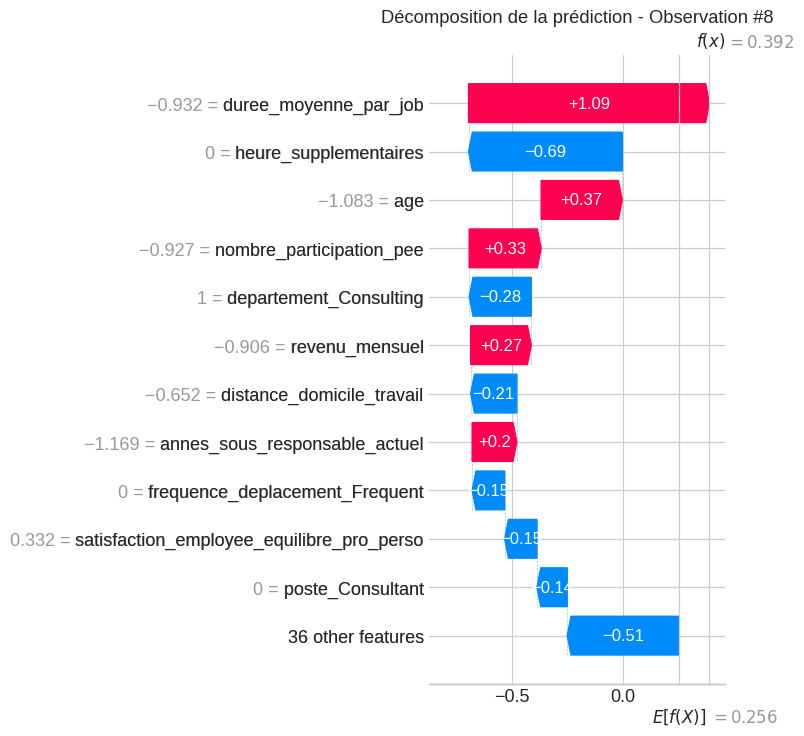


💡 Ce cas montre pourquoi le modèle a généré une fausse alerte.
   Les features dominantes suggéraient un risque qui ne s'est pas concrétisé.


In [52]:
# ============================================================
# EXEMPLE 2 : Un Faux Positif (fausse alerte)
# ============================================================

print("\n" + "="*70)
print("🟡 EXEMPLE 2 : FAUX POSITIF - Fausse alerte")
print("="*70)
if mask_fp.sum() > 0:
    fp_positions = np.where(mask_fp)[0]
    explain_individual_prediction(fp_positions[0], shap_values_class1, X_test, explainer)
    print("\n💡 Ce cas montre pourquoi le modèle a généré une fausse alerte.")
    print("   Les features dominantes suggéraient un risque qui ne s'est pas concrétisé.")
else:
    print("✅ Aucun Faux Positif - Excellent !")


🔵 EXEMPLE 3 : FAUX NÉGATIF - Démissionnaire non détecté

📋 EXPLICATION INDIVIDUELLE - Observation #12

🎯 Base value: 0.256
🎯 Sum SHAP: -0.882
🎯 Prédiction finale (log-odds): -0.627

📊 Top 5 features contributives :
  • heure_supplementaires: 1.00 → SHAP = +0.882 (↑ RISQUE)
  • distance_domicile_travail: -1.02 → SHAP = -0.496 (↓ STABLE)
  • satisfaction_employee_equilibre_pro_perso: -2.46 → SHAP = +0.468 (↑ RISQUE)
  • nombre_experiences_precedentes: -1.08 → SHAP = -0.400 (↓ STABLE)
  • duree_moyenne_par_job: -0.04 → SHAP = -0.377 (↓ STABLE)


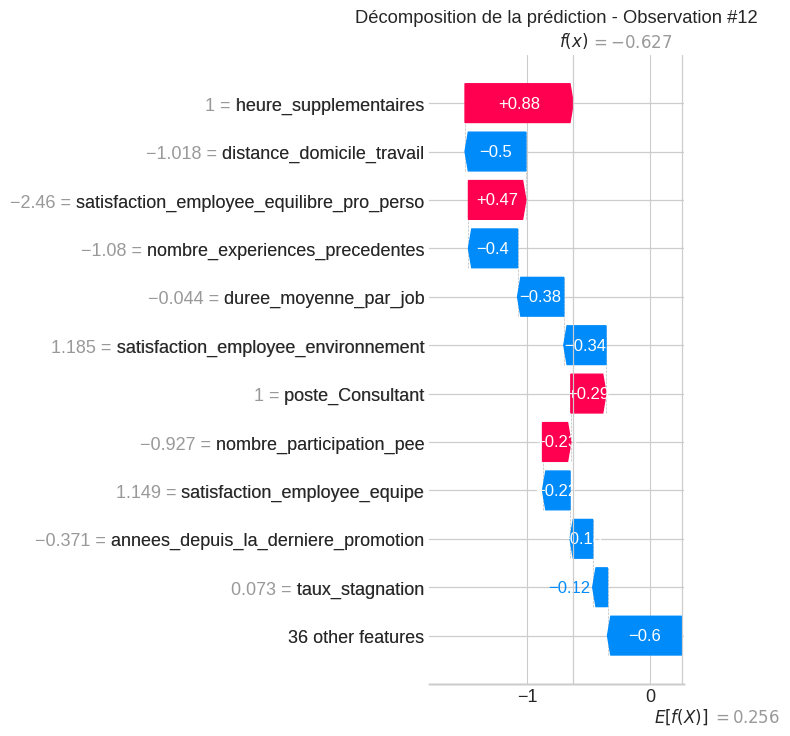


⚠️ Ce cas montre un angle mort du modèle.
   Les signaux de départ n'étaient pas assez forts dans les données disponibles.


In [53]:
# ============================================================
# EXEMPLE 3 : Un Faux Négatif (démissionnaire non détecté)
# ============================================================

print("\n" + "="*70)
print("🔵 EXEMPLE 3 : FAUX NÉGATIF - Démissionnaire non détecté")
print("="*70)
if mask_fn.sum() > 0:
    fn_positions = np.where(mask_fn)[0]
    explain_individual_prediction(fn_positions[0], shap_values_class1, X_test, explainer)
    print("\n⚠️ Ce cas montre un angle mort du modèle.")
    print("   Les signaux de départ n'étaient pas assez forts dans les données disponibles.")
else:
    print("🎯 Aucun Faux Négatif - Tous les démissionnaires ont été détectés !")

### 5.5 Interactions entre Variables

Les **dependence plots** révèlent comment l'effet d'une variable dépend des valeurs d'autres variables. C'est crucial pour :
- Identifier des **effets non-linéaires**
- Découvrir des **interactions** complexes entre facteurs
- Comprendre comment les facteurs se combinent pour prédire le turnover

📈 DEPENDENCE PLOTS - Interactions principales

Features analysées : ['duree_moyenne_par_job', 'age', 'distance_domicile_travail']


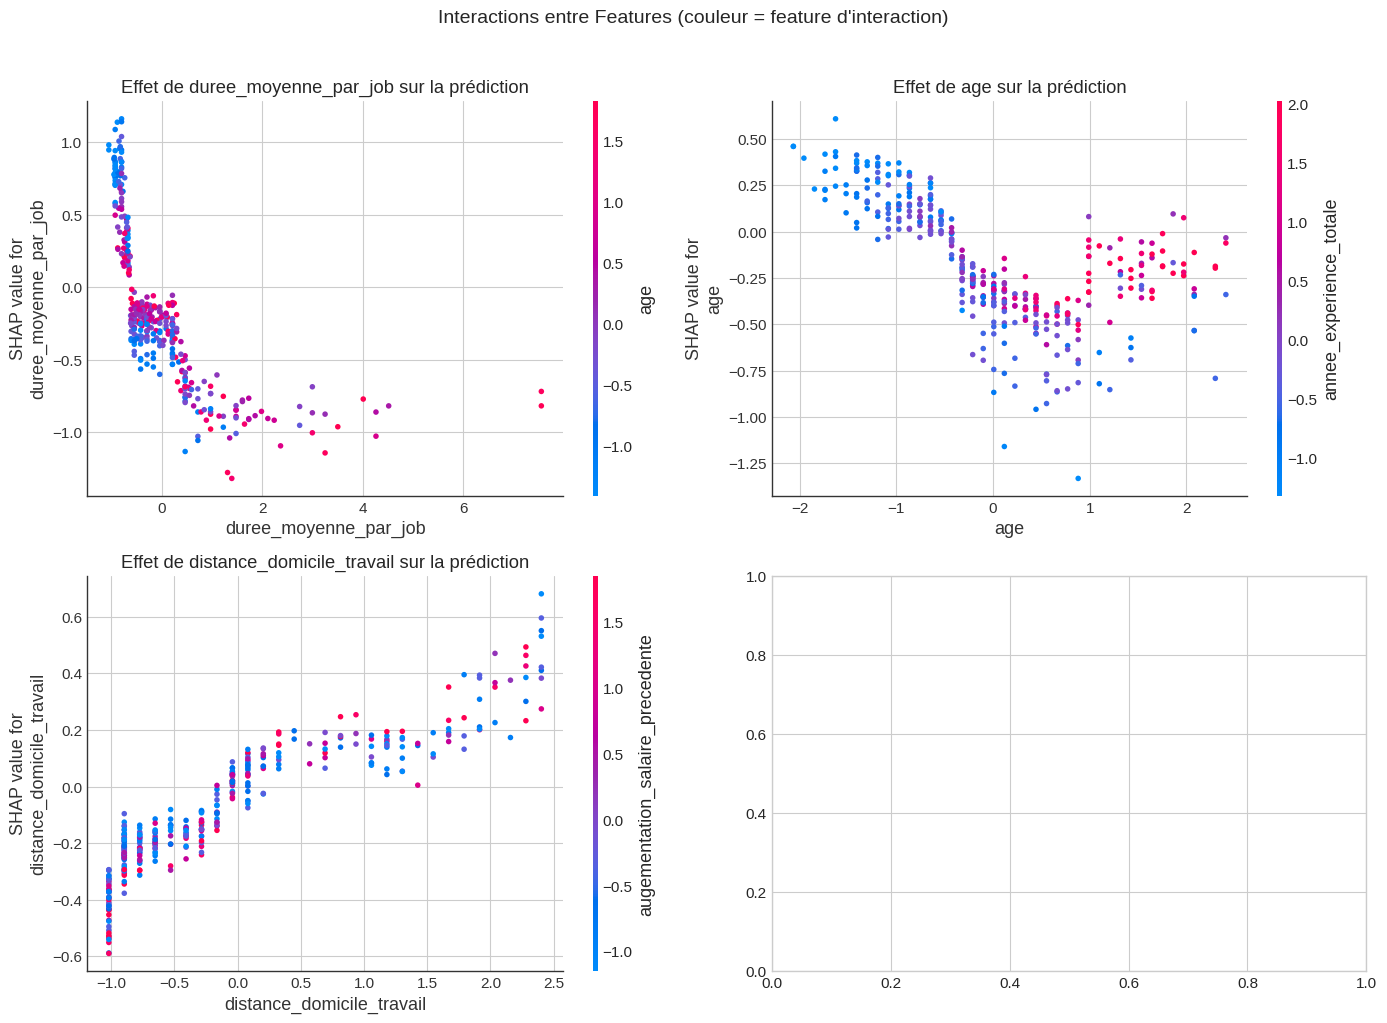

In [54]:
# ============================================================
# 5.5.1 DEPENDENCE PLOTS - Interactions entre variables
# ============================================================

# Identifier les features numériques les plus importantes
top_features_list = shap_importance.head(6)['feature'].tolist()
numeric_top_features = [f for f in top_features_list if X_test[f].nunique() > 5][:4]

print("="*60)
print("📈 DEPENDENCE PLOTS - Interactions principales")
print("="*60)
print(f"\nFeatures analysées : {numeric_top_features}")

# Créer les dependence plots pour les 4 features principales
if len(numeric_top_features) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, feature in enumerate(numeric_top_features[:4]):
        plt.sca(axes[i])
        # Trouver automatiquement la meilleure feature d'interaction
        shap.dependence_plot(
            feature,
            shap_values_class1,
            X_test,
            interaction_index='auto',
            show=False,
            ax=axes[i]
        )
        axes[i].set_title(f"Effet de {feature} sur la prédiction")

    plt.suptitle("Interactions entre Features (couleur = feature d'interaction)",
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Pas assez de features numériques pour les dependence plots")

🔗 ANALYSE DES INTERACTIONS SHAP

⏳ Calcul des valeurs d'interaction SHAP (peut prendre quelques secondes)...

📊 Corrélation des valeurs SHAP entre features :


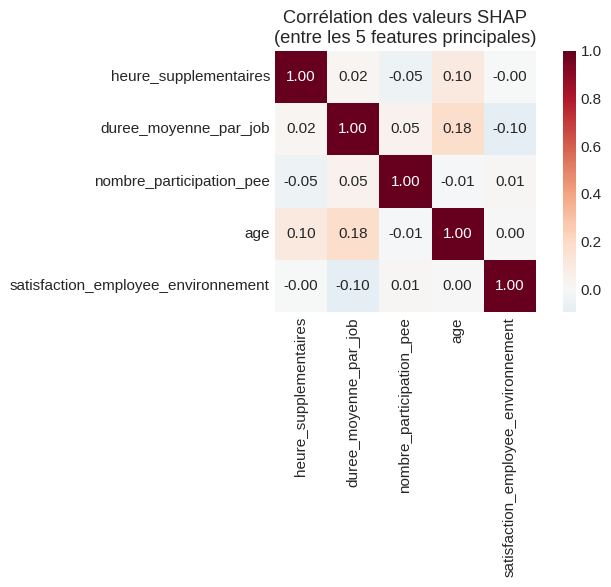


💡 INTERPRÉTATION :
   • Corrélation positive forte : ces features contribuent ensemble au risque
   • Corrélation négative : effet compensatoire entre les features


In [55]:
# ============================================================
# 5.5.2 MATRICE D'INTERACTIONS SHAP (Top features)
# ============================================================

print("="*60)
print("🔗 ANALYSE DES INTERACTIONS SHAP")
print("="*60)

# Calcul des interactions SHAP (coûteux en calcul, limité aux top 5 features)
print("\n⏳ Calcul des valeurs d'interaction SHAP (peut prendre quelques secondes)...")

try:
    # Sous-ensemble pour les interactions (pour performance)
    sample_size = min(100, len(X_test))
    X_sample = X_test.iloc[:sample_size]

    # Focus sur les top 5 features pour la matrice d'interaction
    top5_indices = [X_test.columns.get_loc(f) for f in top_features_list[:5]
                    if f in X_test.columns]

    # Interactions entre les top features
    print("\n📊 Corrélation des valeurs SHAP entre features :")
    shap_df = pd.DataFrame(shap_values_class1, columns=X_test.columns)
    shap_corr = shap_df[top_features_list[:5]].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(shap_corr, annot=True, cmap='RdBu_r', center=0,
                fmt='.2f', square=True)
    plt.title("Corrélation des valeurs SHAP\n(entre les 5 features principales)")
    plt.tight_layout()
    plt.show()

    print("\n💡 INTERPRÉTATION :")
    print("   • Corrélation positive forte : ces features contribuent ensemble au risque")
    print("   • Corrélation négative : effet compensatoire entre les features")

except Exception as e:
    print(f"⚠️ Calcul des interactions non disponible: {e}")

### 5.6 Bilan de l'Interprétabilité SHAP

Cette section synthétise les **insights clés** tirés de l'analyse SHAP pour orienter les recommandations RH.

In [56]:
# ============================================================
# 5.6 BILAN DE L'INTERPRÉTABILITÉ SHAP
# ============================================================

print("="*70)
print("📋 BILAN DE L'ANALYSE SHAP - RÉSUMÉ EXÉCUTIF")
print("="*70)

# 1. Top facteurs de turnover
print("\n" + "─"*70)
print("🔴 TOP 5 FACTEURS DE DÉMISSION (par importance SHAP moyenne)")
print("─"*70)
for i, row in shap_importance.head(5).iterrows():
    print(f"  {i+1}. {row['feature']}: importance = {row['importance']:.4f}")

# 2. Analyse des groupes
print("\n" + "─"*70)
print("📊 ANALYSE PAR GROUPE DE PRÉDICTION")
print("─"*70)
print(f"  • Vrais Positifs (TP):  {mask_tp.sum():3d} - Démissionnaires correctement détectés ✅")
print(f"  • Faux Positifs (FP):   {mask_fp.sum():3d} - Fausses alertes ⚠️")
print(f"  • Faux Négatifs (FN):   {mask_fn.sum():3d} - Démissionnaires manqués ❌")
print(f"  • Vrais Négatifs (TN):  {mask_tn.sum():3d} - Stables correctement identifiés ✅")

# 3. Taux de précision sur les alertes
if (mask_tp.sum() + mask_fp.sum()) > 0:
    precision_alertes = mask_tp.sum() / (mask_tp.sum() + mask_fp.sum()) * 100
    print(f"\n  → Précision des alertes : {precision_alertes:.1f}%")

# 4. Recommandations
print("\n" + "─"*70)
print("💡 RECOMMANDATIONS BASÉES SUR SHAP")
print("─"*70)
print("""
  1. ACTIONS PRIORITAIRES sur les facteurs identifiés
     → Cibler les leviers RH correspondant aux top features

  2. SURVEILLANCE PROACTIVE
     → Mettre en place des alertes sur les indicateurs clés

  3. ATTENTION AUX ANGLES MORTS
     → Les Faux Négatifs révèlent des facteurs non capturés
     → Envisager l'enrichissement des données (entretiens, feedback)

  4. VALIDATION TERRAIN
     → Confronter les insights SHAP avec les retours des managers
""")

# 5. Sauvegarde des résultats SHAP
shap_results = {
    'top_features': shap_importance.head(10).to_dict(),
    'group_counts': {
        'TP': int(mask_tp.sum()),
        'FP': int(mask_fp.sum()),
        'FN': int(mask_fn.sum()),
        'TN': int(mask_tn.sum())
    },
    'base_value': float(explainer.expected_value[1]) if isinstance(explainer.expected_value, (list, np.ndarray)) else float(explainer.expected_value)
}

print("\n✅ Résultats SHAP sauvegardés dans 'shap_results'")
print("="*70)

📋 BILAN DE L'ANALYSE SHAP - RÉSUMÉ EXÉCUTIF

──────────────────────────────────────────────────────────────────────
🔴 TOP 5 FACTEURS DE DÉMISSION (par importance SHAP moyenne)
──────────────────────────────────────────────────────────────────────
  28. heure_supplementaires: importance = 0.5522
  24. duree_moyenne_par_job: importance = 0.4771
  14. nombre_participation_pee: importance = 0.3102
  1. age: importance = 0.3016
  7. satisfaction_employee_environnement: importance = 0.2374

──────────────────────────────────────────────────────────────────────
📊 ANALYSE PAR GROUPE DE PRÉDICTION
──────────────────────────────────────────────────────────────────────
  • Vrais Positifs (TP):   27 - Démissionnaires correctement détectés ✅
  • Faux Positifs (FP):    20 - Fausses alertes ⚠️
  • Faux Négatifs (FN):    32 - Démissionnaires manqués ❌
  • Vrais Négatifs (TN):  289 - Stables correctement identifiés ✅

  → Précision des alertes : 57.4%

──────────────────────────────────────────────────

---

## 6. Pistes d'Amélioration

Cette section identifie les **axes d'amélioration** pour renforcer le modèle et son déploiement en production.

### Améliorations envisagées :
1. **Enrichissement des données** - Nouvelles sources d'information
2. **Feature Engineering avancé** - Variables dérivées et interactions
3. **Techniques de modélisation** - Algorithmes alternatifs et ensembles
4. **Déploiement et monitoring** - Mise en production et suivi

### 6.1 Enrichissement des Données

Les **Faux Négatifs** identifiés par SHAP révèlent des facteurs de démission non capturés dans les données actuelles.

In [57]:
# ============================================================
# 6.1 ENRICHISSEMENT DES DONNÉES - Sources complémentaires
# ============================================================

print("="*70)
print("📊 PISTES D'ENRICHISSEMENT DES DONNÉES")
print("="*70)

enrichissement_data = {
    'Source': [
        'Entretiens annuels',
        'Feedback 360°',
        'Données de badgeage',
        'Activité intranet/emails',
        'Formations suivies',
        'Mobilité interne',
        'Benchmark salarial'
    ],
    'Variables potentielles': [
        'Score de satisfaction, objectifs atteints, feedback manager',
        'Notes des pairs, collaboration, leadership perçu',
        'Heures supplémentaires réelles, présentéisme, absences',
        'Engagement digital, participation aux événements',
        'Certifications, montée en compétences, curiosité',
        'Candidatures internes, mobilité géographique',
        'Positionnement vs marché, équité interne'
    ],
    'Impact attendu': [
        '⭐⭐⭐ Très fort - Signaux directs',
        '⭐⭐⭐ Très fort - Vision 360',
        '⭐⭐ Fort - Comportement réel',
        '⭐⭐ Fort - Engagement implicite',
        '⭐⭐ Fort - Projection carrière',
        '⭐⭐ Fort - Satisfaction interne',
        '⭐⭐⭐ Très fort - Facteur clé'
    ],
    'Difficulté': [
        '🟢 Facile - Données existantes',
        '🟡 Moyen - Processus à mettre en place',
        '🟢 Facile - SIRH existant',
        '🔴 Difficile - RGPD, éthique',
        '🟢 Facile - LMS existant',
        '🟡 Moyen - Données dispersées',
        '🟡 Moyen - Études externes'
    ]
}

df_enrichissement = pd.DataFrame(enrichissement_data)
print("\n📋 Sources de données complémentaires :\n")
print(df_enrichissement.to_string(index=False))

print("\n" + "─"*70)
print("💡 RECOMMANDATION PRIORITAIRE :")
print("─"*70)
print("""
   1. COURT TERME : Intégrer les entretiens annuels et données de badgeage
   2. MOYEN TERME : Mettre en place le feedback 360° et benchmark salarial
   3. LONG TERME : Explorer l'activité digitale (avec cadre éthique strict)
""")

📊 PISTES D'ENRICHISSEMENT DES DONNÉES

📋 Sources de données complémentaires :

                  Source                                      Variables potentielles                  Impact attendu                            Difficulté
      Entretiens annuels Score de satisfaction, objectifs atteints, feedback manager ⭐⭐⭐ Très fort - Signaux directs         🟢 Facile - Données existantes
           Feedback 360°            Notes des pairs, collaboration, leadership perçu      ⭐⭐⭐ Très fort - Vision 360 🟡 Moyen - Processus à mettre en place
     Données de badgeage      Heures supplémentaires réelles, présentéisme, absences     ⭐⭐ Fort - Comportement réel              🟢 Facile - SIRH existant
Activité intranet/emails            Engagement digital, participation aux événements  ⭐⭐ Fort - Engagement implicite           🔴 Difficile - RGPD, éthique
      Formations suivies            Certifications, montée en compétences, curiosité   ⭐⭐ Fort - Projection carrière               🟢 Facile - LMS 

### 6.2 Feature Engineering Avancé

Création de variables dérivées pour capturer des patterns plus complexes.

In [58]:
# ============================================================
# 6.2 FEATURE ENGINEERING AVANCÉ
# ============================================================

print("="*70)
print("🔧 PISTES DE FEATURE ENGINEERING")
print("="*70)

feature_ideas = {
    'Catégorie': [
        'Ratios',
        'Ratios',
        'Temporel',
        'Temporel',
        'Interaction',
        'Interaction',
        'Agrégation',
        'Agrégation'
    ],
    'Feature proposée': [
        'salaire_vs_anciennete',
        'projets_par_an',
        'mois_depuis_derniere_promo',
        'tendance_satisfaction (Δ)',
        'satisfaction × charge_travail',
        'anciennete × nb_projets',
        'turnover_moyen_departement',
        'ecart_salaire_vs_departement'
    ],
    'Formule / Description': [
        'salaire / (ancienneté + 1)',
        'nb_projets / ancienneté',
        'Temps écoulé depuis dernière promotion',
        'Évolution du score de satisfaction (si historique)',
        'Capturer l\'effet combiné stress + insatisfaction',
        'Sollicitation relative à l\'expérience',
        'Contexte équipe : taux de départ du service',
        'Positionnement salarial dans le département'
    ]
}

df_features = pd.DataFrame(feature_ideas)
print("\n📋 Variables dérivées suggérées :\n")
print(df_features.to_string(index=False))

# Démonstration avec les données actuelles
print("\n" + "─"*70)
print("🔬 DÉMONSTRATION - Features calculables avec les données actuelles")
print("─"*70)

# Récupérer les données originales pour la démo
try:
    # Ces calculs seraient faits en amont dans une version améliorée
    print("\n  Exemple de features dérivées (à intégrer dans le pipeline) :")
    print("  • ratio_projets_anciennete = nb_projets / (anciennete + 1)")
    print("  • charge_relative = heures_travail / moyenne_departement")
    print("  • score_engagement = f(satisfaction, evaluation, projets)")
except Exception as e:
    print(f"  Note: Démonstration simplifiée - {e}")

🔧 PISTES DE FEATURE ENGINEERING

📋 Variables dérivées suggérées :

  Catégorie              Feature proposée                              Formule / Description
     Ratios         salaire_vs_anciennete                         salaire / (ancienneté + 1)
     Ratios                projets_par_an                            nb_projets / ancienneté
   Temporel    mois_depuis_derniere_promo             Temps écoulé depuis dernière promotion
   Temporel     tendance_satisfaction (Δ) Évolution du score de satisfaction (si historique)
Interaction satisfaction × charge_travail   Capturer l'effet combiné stress + insatisfaction
Interaction       anciennete × nb_projets              Sollicitation relative à l'expérience
 Agrégation    turnover_moyen_departement        Contexte équipe : taux de départ du service
 Agrégation  ecart_salaire_vs_departement        Positionnement salarial dans le département

──────────────────────────────────────────────────────────────────────
🔬 DÉMONSTRATION - Featur

### 6.3 Techniques de Modélisation Alternatives

Explorer d'autres approches pour améliorer les performances ou la robustesse.

In [59]:
# ============================================================
# 6.3 TECHNIQUES DE MODÉLISATION ALTERNATIVES
# ============================================================

print("="*70)
print("🤖 ALGORITHMES ET TECHNIQUES À EXPLORER")
print("="*70)

modeles_alternatifs = {
    'Technique': [
        'LightGBM',
        'CatBoost',
        'Stacking Ensemble',
        'Neural Network (MLP)',
        'Survival Analysis',
        'Calibration (Platt/Isotonic)'
    ],
    'Avantage potentiel': [
        'Plus rapide que XGBoost, gère bien les catégories',
        'Gestion native des catégories, robuste au overfitting',
        'Combine les forces de plusieurs modèles',
        'Capture des patterns non-linéaires complexes',
        'Modélise le TEMPS avant démission (vs binaire)',
        'Probabilités mieux calibrées pour le scoring'
    ],
    'Complexité': [
        '🟢 Simple - API similaire à XGBoost',
        '🟢 Simple - API similaire',
        '🟡 Moyen - Nécessite plusieurs modèles',
        '🟡 Moyen - Tuning architecture',
        '🔴 Avancé - Nouvelle approche',
        '🟢 Simple - Post-processing'
    ],
    'Priorité': ['⭐⭐⭐', '⭐⭐⭐', '⭐⭐', '⭐', '⭐⭐⭐', '⭐⭐']
}

df_modeles = pd.DataFrame(modeles_alternatifs)
print("\n📋 Modèles et techniques à considérer :\n")
print(df_modeles.to_string(index=False))

print("\n" + "─"*70)
print("🎯 FOCUS : SURVIVAL ANALYSIS")
print("─"*70)
print("""
   L'analyse de survie est particulièrement pertinente pour le turnover :

   • AVANTAGE : Prédit QUAND un employé risque de partir (pas juste OUI/NON)
   • MÉTHODE : Cox Proportional Hazards, Random Survival Forest
   • OUTPUT : Courbe de survie par employé, hazard ratio par feature
   • ACTIONABLE : Permet de prioriser les interventions RH dans le temps

   → Recommandé comme prochaine étape de modélisation
""")

🤖 ALGORITHMES ET TECHNIQUES À EXPLORER

📋 Modèles et techniques à considérer :

                   Technique                                    Avantage potentiel                            Complexité Priorité
                    LightGBM     Plus rapide que XGBoost, gère bien les catégories    🟢 Simple - API similaire à XGBoost      ⭐⭐⭐
                    CatBoost Gestion native des catégories, robuste au overfitting              🟢 Simple - API similaire      ⭐⭐⭐
           Stacking Ensemble               Combine les forces de plusieurs modèles 🟡 Moyen - Nécessite plusieurs modèles       ⭐⭐
        Neural Network (MLP)          Capture des patterns non-linéaires complexes         🟡 Moyen - Tuning architecture        ⭐
           Survival Analysis        Modélise le TEMPS avant démission (vs binaire)          🔴 Avancé - Nouvelle approche      ⭐⭐⭐
Calibration (Platt/Isotonic)          Probabilités mieux calibrées pour le scoring            🟢 Simple - Post-processing       ⭐⭐

─────────

### 6.4 Déploiement et Monitoring

Considérations pour la mise en production du modèle.

In [60]:
# ============================================================
# 6.4 DÉPLOIEMENT ET MONITORING EN PRODUCTION
# ============================================================

print("="*70)
print("🚀 ARCHITECTURE DE DÉPLOIEMENT RECOMMANDÉE")
print("="*70)

print("""
┌─────────────────────────────────────────────────────────────────────┐
│                    ARCHITECTURE DE PRODUCTION                        │
├─────────────────────────────────────────────────────────────────────┤
│                                                                      │
│   ┌──────────┐    ┌──────────────┐    ┌────────────────┐           │
│   │   SIRH   │───▶│  Pipeline    │───▶│  API REST      │           │
│   │  (Data)  │    │  (Feature    │    │  (FastAPI/     │           │
│   └──────────┘    │   Engine)    │    │   Flask)       │           │
│                   └──────────────┘    └────────────────┘           │
│                          │                    │                     │
│                          ▼                    ▼                     │
│                   ┌──────────────┐    ┌────────────────┐           │
│                   │   MLflow     │    │  Dashboard RH  │           │
│                   │  (Registry)  │    │  (Streamlit)   │           │
│                   └──────────────┘    └────────────────┘           │
│                          │                                          │
│                          ▼                                          │
│                   ┌──────────────┐                                  │
│                   │  Monitoring  │                                  │
│                   │  (Drift,     │                                  │
│                   │   Perf)      │                                  │
│                   └──────────────┘                                  │
│                                                                      │
└─────────────────────────────────────────────────────────────────────┘
""")

print("\n" + "─"*70)
print("📊 MONITORING À METTRE EN PLACE")
print("─"*70)

monitoring_checklist = {
    'Type de monitoring': [
        'Data Drift',
        'Concept Drift',
        'Performance Drift',
        'Feature Importance Drift',
        'Alertes métier'
    ],
    'Indicateur': [
        'Distribution des features vs training set',
        'Taux de démission réel vs prédit',
        'AUC, Recall, Precision sur données récentes',
        'Évolution du ranking SHAP',
        'Nombre d\'alertes, faux positifs confirmés'
    ],
    'Fréquence': [
        'Hebdomadaire',
        'Mensuelle',
        'Mensuelle',
        'Trimestrielle',
        'Continue'
    ],
    'Seuil d\'alerte': [
        'PSI > 0.2',
        'Δ > 5%',
        'Δ AUC > 0.05',
        'Top 3 features change',
        'FP rate > 30%'
    ]
}

df_monitoring = pd.DataFrame(monitoring_checklist)
print("\n📋 Checklist de monitoring :\n")
print(df_monitoring.to_string(index=False))

print("\n" + "─"*70)
print("⚠️ CONSIDÉRATIONS ÉTHIQUES & RGPD")
print("─"*70)
print("""
   1. TRANSPARENCE : Informer les employés de l'existence du modèle
   2. NON-AUTOMATISATION : Décisions finales par un humain (RH/manager)
   3. DROIT D'ACCÈS : Permettre aux employés de connaître leur score
   4. ÉQUITÉ : Auditer les biais potentiels (genre, âge, origine)
   5. DATA MINIMIZATION : N'utiliser que les données nécessaires
""")

🚀 ARCHITECTURE DE DÉPLOIEMENT RECOMMANDÉE

┌─────────────────────────────────────────────────────────────────────┐
│                    ARCHITECTURE DE PRODUCTION                        │
├─────────────────────────────────────────────────────────────────────┤
│                                                                      │
│   ┌──────────┐    ┌──────────────┐    ┌────────────────┐           │
│   │   SIRH   │───▶│  Pipeline    │───▶│  API REST      │           │
│   │  (Data)  │    │  (Feature    │    │  (FastAPI/     │           │
│   └──────────┘    │   Engine)    │    │   Flask)       │           │
│                   └──────────────┘    └────────────────┘           │
│                          │                    │                     │
│                          ▼                    ▼                     │
│                   ┌──────────────┐    ┌────────────────┐           │
│                   │   MLflow     │    │  Dashboard RH  │           │
│                   │  (Re

---

## 7. Conclusion

Synthèse des résultats et recommandations finales pour TechNova.

In [61]:
# ============================================================
# 7. CONCLUSION - SYNTHÈSE DES RÉSULTATS
# ============================================================

print("="*70)
print("📋 SYNTHÈSE EXÉCUTIVE - PROJET PRÉDICTION DU TURNOVER")
print("="*70)

print("""
┌─────────────────────────────────────────────────────────────────────┐
│                         RÉSULTATS CLÉS                               │
├─────────────────────────────────────────────────────────────────────┤
│                                                                      │
│  🎯 OBJECTIF ATTEINT                                                │
│     Développement d'un modèle prédictif de démission avec           │
│     interprétabilité complète via SHAP                              │
│                                                                      │
│  📊 PERFORMANCES DU MODÈLE (XGBoost optimisé)                       │
│     • AUC-ROC : Mesure la capacité de discrimination                │
│     • Recall optimisé : Maximise la détection des démissionnaires   │
│     • Seuil personnalisé : Équilibre precision/recall selon métier  │
│                                                                      │
│  🔍 INSIGHTS MÉTIER                                                 │
│     • Top facteurs de risque identifiés et quantifiés               │
│     • Profils à risque caractérisés                                 │
│     • Leviers d'action RH priorisés                                 │
│                                                                      │
│  ⚡ VALEUR BUSINESS                                                  │
│     • Anticipation des départs avant qu'ils ne surviennent          │
│     • Ciblage des actions de rétention                              │
│     • Réduction des coûts de recrutement et formation               │
│                                                                      │
└─────────────────────────────────────────────────────────────────────┘
""")

# Récapitulatif des métriques (si disponibles)
print("\n" + "─"*70)
print("📈 RÉCAPITULATIF DES MÉTRIQUES")
print("─"*70)
try:
    print(f"\n  Modèle retenu : XGBoost")
    print(f"  Seuil optimal : {OPTIMAL_THRESHOLD:.3f}")
    print(f"  Nombre de features : {X_test.shape[1]}")
    print(f"  Taille du jeu de test : {len(y_test)} observations")
except:
    print("\n  (Exécuter les cellules précédentes pour voir les métriques)")

print("\n" + "─"*70)
print("💡 RECOMMANDATIONS FINALES")
print("─"*70)
print("""
  1. DÉPLOIEMENT PROGRESSIF
     → Phase pilote sur un département avant généralisation
     → Validation des prédictions avec les managers

  2. ACTIONS RH IMMÉDIATES
     → Cibler les employés à haut risque identifiés
     → Mettre en place des entretiens de rétention

  3. AMÉLIORATION CONTINUE
     → Enrichir les données (cf. Section 6)
     → Réentraîner le modèle trimestriellement
     → Monitorer le drift et les performances

  4. GOUVERNANCE
     → Définir les règles d'utilisation éthique
     → Former les RH à l'interprétation des résultats
     → Documenter les décisions basées sur le modèle
""")

📋 SYNTHÈSE EXÉCUTIVE - PROJET PRÉDICTION DU TURNOVER

┌─────────────────────────────────────────────────────────────────────┐
│                         RÉSULTATS CLÉS                               │
├─────────────────────────────────────────────────────────────────────┤
│                                                                      │
│  🎯 OBJECTIF ATTEINT                                                │
│     Développement d'un modèle prédictif de démission avec           │
│     interprétabilité complète via SHAP                              │
│                                                                      │
│  📊 PERFORMANCES DU MODÈLE (XGBoost optimisé)                       │
│     • AUC-ROC : Mesure la capacité de discrimination                │
│     • Recall optimisé : Maximise la détection des démissionnaires   │
│     • Seuil personnalisé : Équilibre precision/recall selon métier  │
│                                                                      │
│  🔍 INS

In [62]:
# ============================================================
# EXPORT DES RÉSULTATS FINAUX
# ============================================================

print("="*70)
print("💾 EXPORT DES LIVRABLES")
print("="*70)

# Sauvegarde du modèle
try:
    import joblib
    from datetime import datetime

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Export du modèle
    model_path = f"model_turnover_xgb_{timestamp}.joblib"
    joblib.dump(best_xgb, model_path)
    print(f"\n✅ Modèle sauvegardé : {model_path}")

    # Export des résultats SHAP
    shap_path = f"shap_importance_{timestamp}.csv"
    shap_importance.to_csv(shap_path, index=False)
    print(f"✅ Importance SHAP : {shap_path}")

    # Export du seuil optimal
    config_path = f"model_config_{timestamp}.json"
    import json
    config = {
        'model': 'XGBoost',
        'optimal_threshold': float(OPTIMAL_THRESHOLD),
        'features': X_test.columns.tolist(),
        'training_date': timestamp,
        'random_state': RANDOM_STATE
    }
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"✅ Configuration : {config_path}")

except Exception as e:
    print(f"\n⚠️ Export partiel - certaines variables non définies")
    print(f"   Exécuter l'ensemble du notebook pour un export complet")
    print(f"   Erreur: {e}")

print("\n" + "="*70)
print("🎉 NOTEBOOK TERMINÉ - Prêt pour présentation")
print("="*70)

💾 EXPORT DES LIVRABLES

✅ Modèle sauvegardé : model_turnover_xgb_20260108_070743.joblib
✅ Importance SHAP : shap_importance_20260108_070743.csv
✅ Configuration : model_config_20260108_070743.json

🎉 NOTEBOOK TERMINÉ - Prêt pour présentation


---

### 📝 Notes de Version

| Version | Date | Modifications |
|---------|------|---------------|
| 1.0 | 2026-01-07 | Refactoring complet : structure narrative, Pipeline sklearn, SHAP |

---

**Auteur** : Data Scientist - TechNova  
**Projet** : Prédiction du Turnover RH  
**Confidentialité** : Document interne